In [1]:
#!/usr/bin/python

# Authors:       Miles(Ye Yuhao).
# Date:          05.26.2023.
# Update:        10.13.2023.
# Correspondace: milesyeyuhao@gmail.com

In [15]:
print('''\u001b[37m-----------------------------------------------------------------------------------------\u001b[33m
 _____  _   _  ________   _____  ___ _____      ______  _____  _____  _____  _____  _   _ 
|  ___|| \ | ||___  /\ \ / /|  \/  ||  ___|     |  _  \|  ___|/  ___||_   _||  __ \| \ | |
| |__  |  \| |   / /  \ V / | .  . || |__       | | | || |__  \ `--.   | |  | |  \/|  \| |
|  __| | . ` |  / /    \ /  | |\/| ||  __|      | | | ||  __|  `--. \  | |  | | __ | . ` |
| |___ | |\  |./ /___  | |  | |  | || |___      | |/ / | |___ /\__/ / _| |_ | |_\ \| |\  |
\____/ \_| \_/\_____/  \_/  \_|  |_/\____/      |___/  \____/ \____/  \___/  \____/\_| \_/                                                                      
                                                                                          
\u001b[33mAuthors:       \x1b[33mMiles(Ye Yuhao).
\u001b[33mDate:          \x1b[33m10.13.2023.
\u001b[33mCorrespondace: \x1b[33mmilesyeyuhao@gmail.com
\u001b[37m------------------------------------------------------------------------------------------''')

-----------------------------------------------------------------------------------------

 _____  _   _  ________   _____  ___ _____      ______  _____  _____  _____  _____  _   _ 

|  ___|| \ | ||___  /\ \ / /|  \/  ||  ___|     |  _  \|  ___|/  ___||_   _||  __ \| \ | |

| |__  |  \| |   / /  \ V / | .  . || |__       | | | || |__  \ `--.   | |  | |  \/|  \| |

|  __| | . ` |  / /    \ /  | |\/| ||  __|      | | | ||  __|  `--. \  | |  | | __ | . ` |

| |___ | |\  |./ /___  | |  | |  | || |___      | |/ / | |___ /\__/ / _| |_ | |_\ \| |\  |

\____/ \_| \_/\_____/  \_/  \_|  |_/\____/      |___/  \____/ \____/  \___/  \____/\_| \_/                                                                      

                                                                                          

Authors:       Miles(Ye Yuhao).

Date:          10.13.2023.

Correspondace: milesyeyuhao@gmail.com

------------------------------------------------------------------------------------------


### 写在前面的话

主要策略是：

<font color="blue">
    
1.首先使用CNN+BiLSTM双向训练数据，拟合一个模型model；

2.对6个突变位点进行6的19次方（不考虑Cys）进行序列列举：单点突变、双点突变等，得到突变空间；

3.用数据训练的模型model去从这突变空间中选取排名靠前的600条序列；

4.紧接着使用Rosetta对这600条序列进行约束，打分，过滤得到300条序列；

5.最后用DKLcat再次过滤，得到96条最优突变子。
</font>





<font color="red">
    
总结（出于自己的理解，错误会很多）：

- 对于这个notebook中的模型我个人觉得有点过于随机，序列的参数有点不靠谱..多次调参都无较好的表现，最后的label我也只是加乘解决，不知道是否可以通过加权解决；

- 一方面，在这里很难确定”环境参数“一说，比如rosetta的打分中，当指定不同的打分函数，表现相差较大；

-  另一方面，亲和力和酶的活性似乎相关不大（猜测），因为酶的活性是kcat模型相关的，或许，可以考虑结构信息到训练网络中，暂时不知道怎么开始构造；

- Attention is all U need!
    
</font>

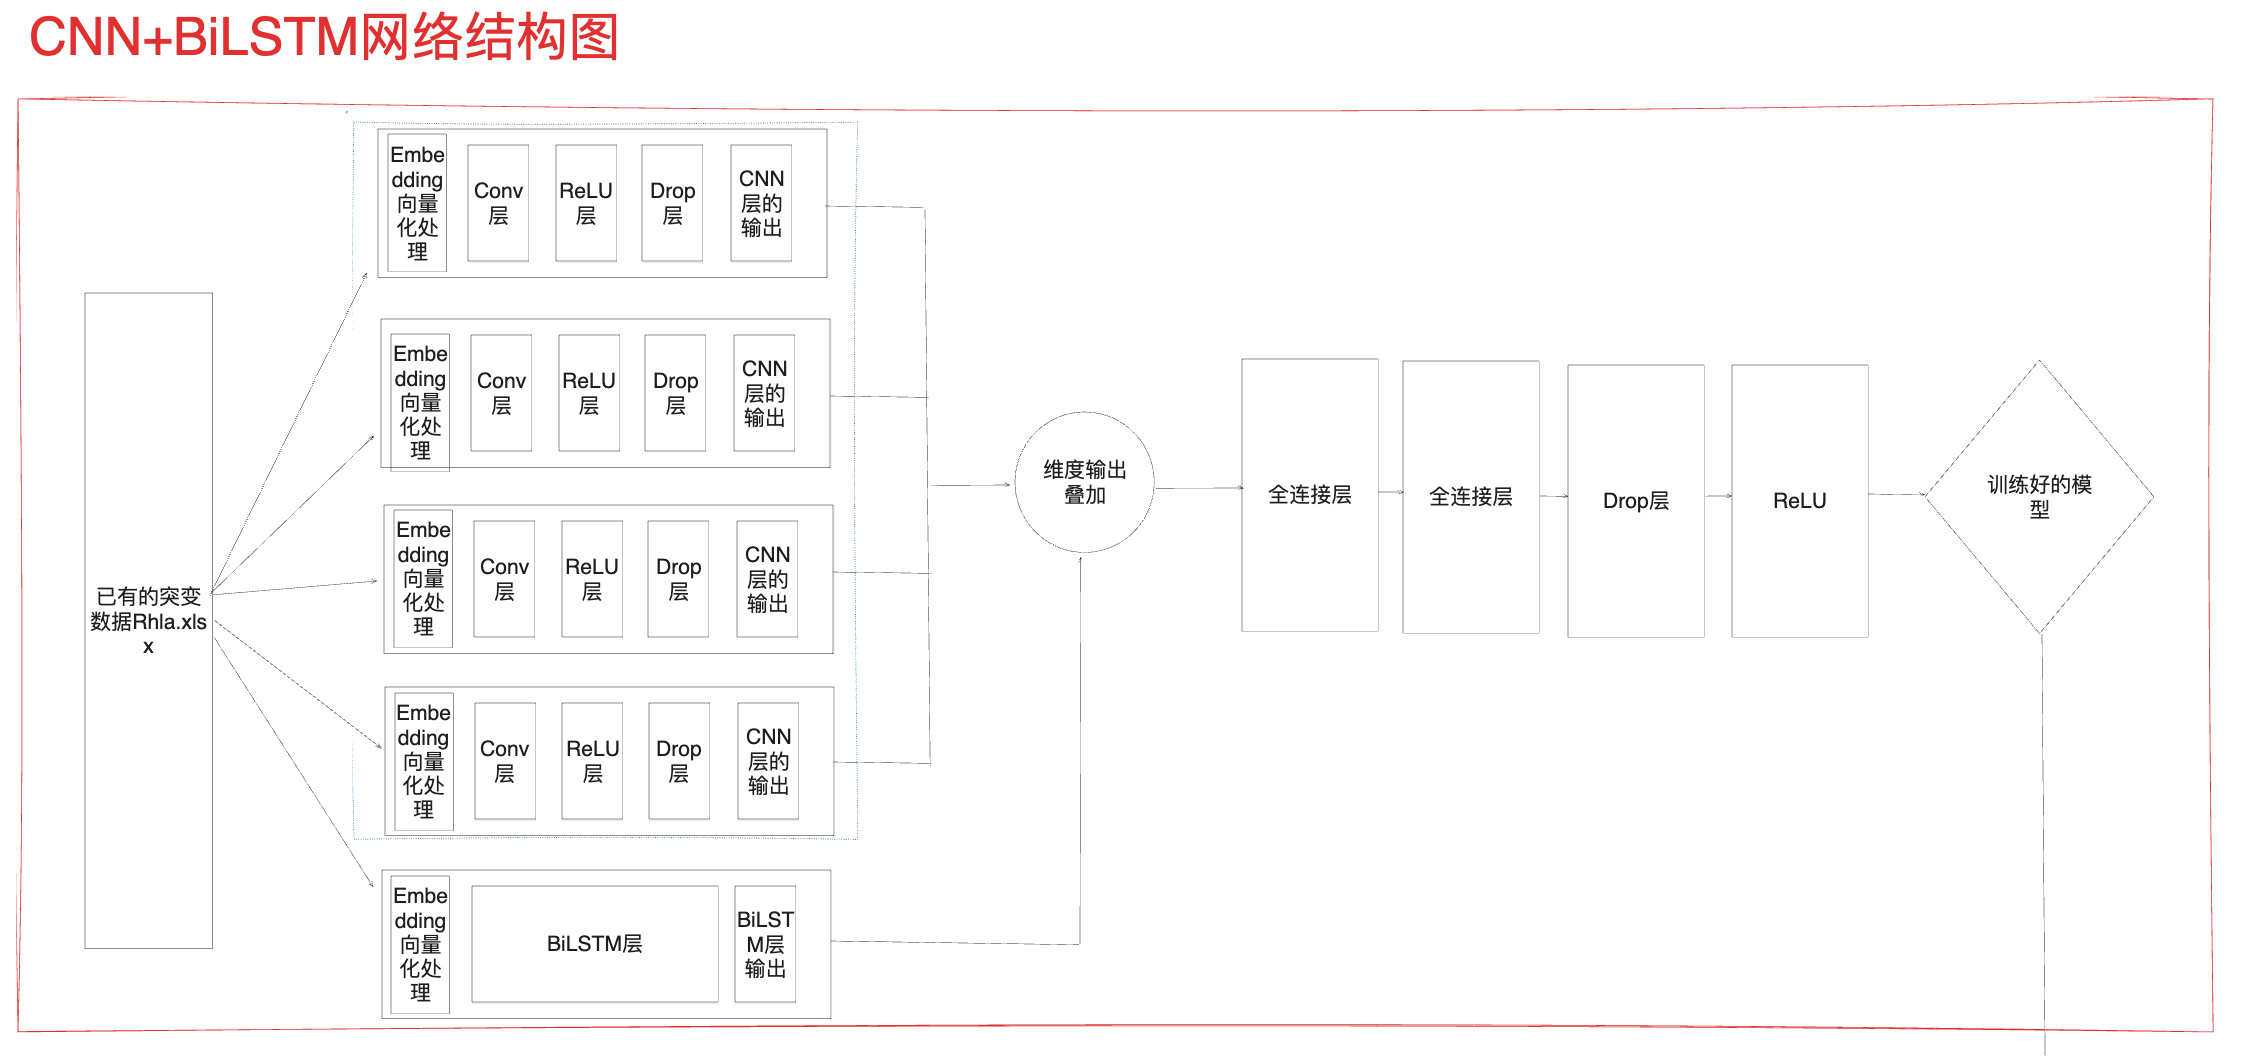

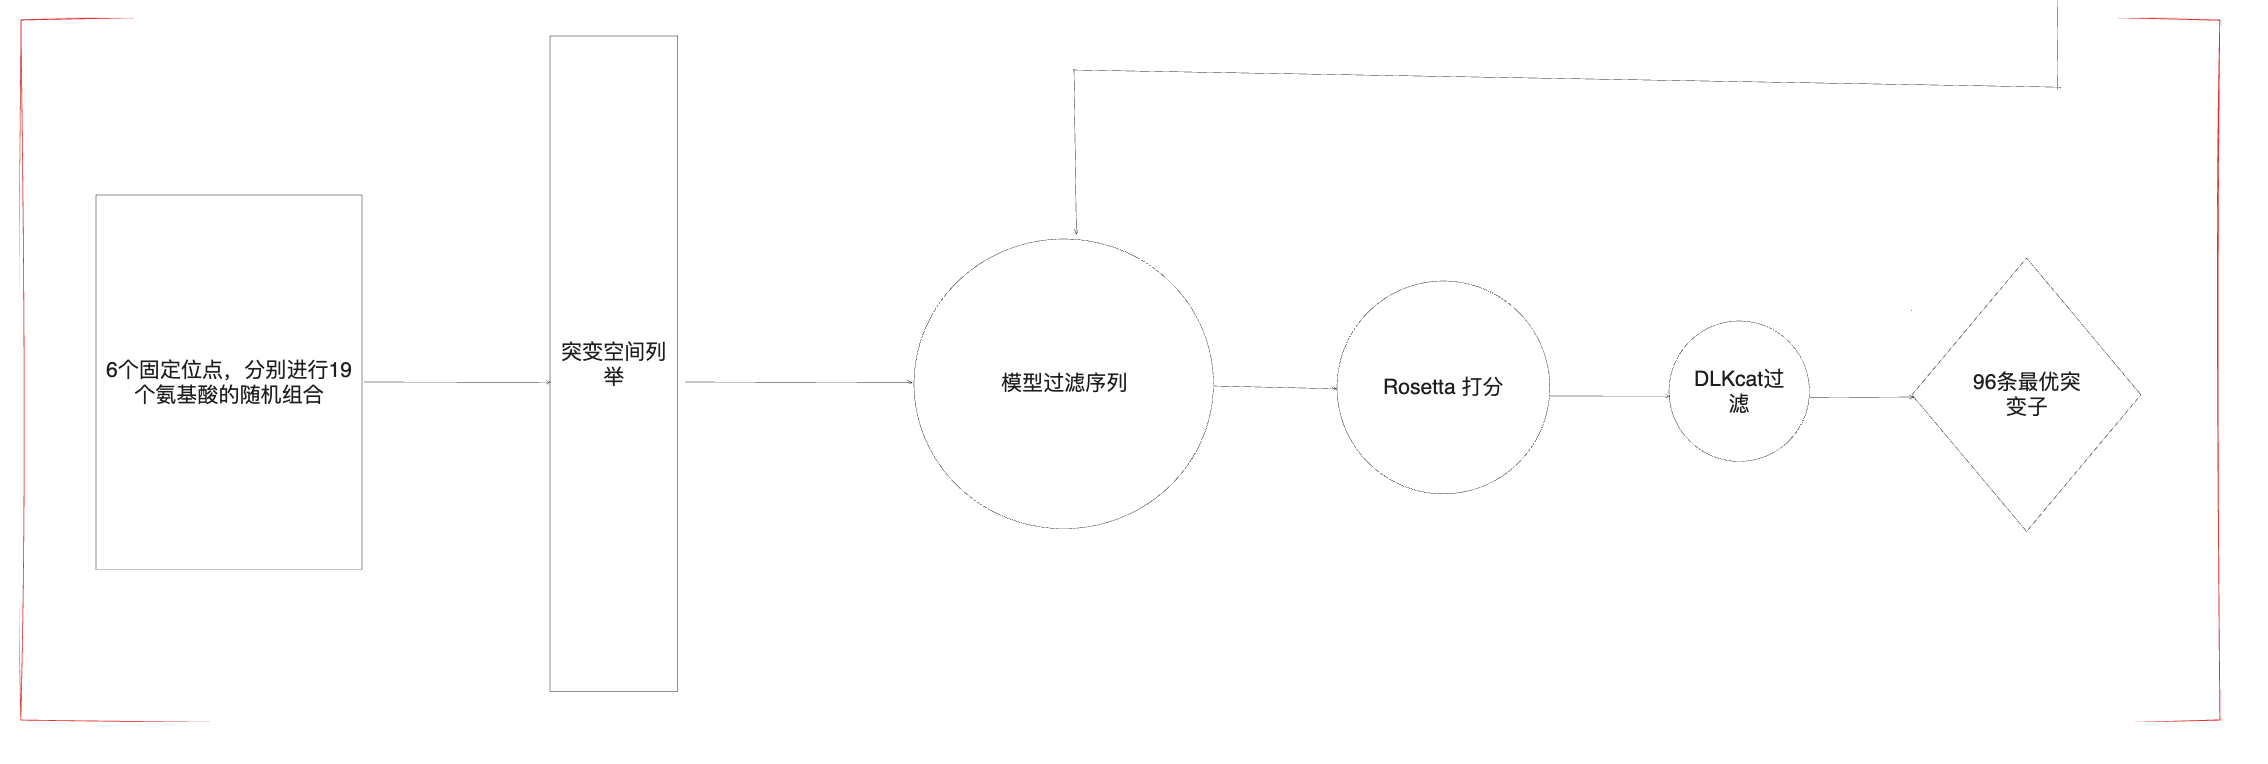

In [3]:
#import package  13.10.202 全部放在一起了
#导包
from io import StringIO
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

from pyrosetta import *
from pyrosetta.toolbox import *

import pdb
# !pip install openpyxl pytorch

### P1.数据观察和预处理 

In [4]:
# Padding Seq & Constraint 
# 补齐野生型蛋白序列，方便后面进行约束、NLP空间探索、训练等

wild_type_seq = """MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFARTCKCLAEHFNVVLFDLPFAGQSRQHNPQRGLITKDDEVEILLALIERFEVNHLVSASWGGISTLLALSRNPRGIRSSVVMAFAPGLNQAMLDYVGRAQALIELDDKSAIGHLLNETVGKYLPQRLKASNHQHMASLATGEYEQARFHIDQVLALNDRGYLACLERIQSHVHFINGSWDEYTTAEDARQFRDYLPHCSFSRVEGTGHFLDLESKLAAVRVHRALLEHLLKQPEPQRAERAAGFHEMAIGYA"""
# len(wild_type_seq)

raw_postion = {
    "74":"R",
    "101":"A",
    "143":"Q",
    "148":"L",
    "173":"S",
    "176":"Q"
}

#突变位点：R74	A101	Q143	L148	S173	Q176  # 注意index-1
# wild_type_seq[100]

# raw_data = pd.read_excel("../../data/siatprotein2023/Rhla.xlsx")
raw_data = pd.read_excel("../../data/siatprotein2023/Rhla_simple.xlsx")

print(len(raw_data))
raw_data.head()

160


,Sequence,74,101,143,148,173,176,Normalized Activity,Normalized Selectivity,label
0,RAQLSQ,R,A,Q,L,S,Q,1.000000,1.000000,1.000000
1,AAQLSQ,A,A,Q,L,S,Q,3.228405,1.836564,5.929171
2,CAQLSQ,C,A,Q,L,S,Q,2.169509,2.445377,5.305268
3,DAQLSQ,D,A,Q,L,S,Q,1.758631,1.060698,1.865376
4,EAQLSQ,E,A,Q,L,S,Q,1.531251,1.031679,1.579759


In [5]:
raw_data = raw_data.iloc[:,:-1]
raw_data

,Sequence,74,101,143,148,173,176,Normalized Activity,Normalized Selectivity
0,RAQLSQ,R,A,Q,L,S,Q,1.000000,1.000000
1,AAQLSQ,A,A,Q,L,S,Q,3.228405,1.836564
2,CAQLSQ,C,A,Q,L,S,Q,2.169509,2.445377
3,DAQLSQ,D,A,Q,L,S,Q,1.758631,1.060698
4,EAQLSQ,E,A,Q,L,S,Q,1.531251,1.031679
...,...,...,...,...,...,...,...,...,...
155,MAQKCQ,M,A,Q,Q,K,Q,0.124900,3.821374
156,NAQKCQ,N,A,Q,Q,K,Q,0.641418,1.996675
157,HAQALQ,H,A,Q,Q,A,Q,0.469483,3.477138
158,TAQARQ,T,A,Q,Q,A,Q,0.675533,2.979725


In [6]:
#将raw_data中的sequence补全
raw_data.iloc[1,1]#74位点
raw_postion = {
    "74":"R",
    "101":"A",
    "143":"Q",
    "148":"L",
    "173":"S",
    "176":"Q"
}

import warnings
warnings.filterwarnings("ignore")
import pdb
# import tqdm
from tqdm import tqdm
import time
# new_data = pd.DataFrame()
# new_data = []

for data in tqdm(range(len(raw_data))):
    time.sleep(0.0001)
    a = raw_data.iloc[data]
#     print("第{}条蛋白序列正在修改".format(data))
    wild_seq = list(wild_type_seq)
    for pos_num in raw_postion.keys():
        new_aa = str(a[int(pos_num)])
#         print(new_aa)
        if wild_seq[int(pos_num)-1] == raw_postion[pos_num]:
            wild_seq[int(pos_num)-1] = new_aa
    new_seq = "".join(wild_seq)
    raw_data.iloc[data,0] = new_seq
#     print(new_seq)
#     print("第{}条蛋白序列正在修改".format(data))
    
        
#         pdb.set_trace()
        
        
        
print("序列转化成功!")

  0%|          | 0/160 [00:00<?, ?it/s]100%|██████████| 160/160 [00:00<00:00, 3186.75it/s]

序列转化成功!


In [7]:
raw_test_data = raw_data.copy()
raw_test_data

# raw_test_data = raw_test_data.iloc[:,:-1]
# raw_test_data

,Sequence,74,101,143,148,173,176,Normalized Activity,Normalized Selectivity
0,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,R,A,Q,L,S,Q,1.000000,1.000000
1,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,A,A,Q,L,S,Q,3.228405,1.836564
2,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,C,A,Q,L,S,Q,2.169509,2.445377
3,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,D,A,Q,L,S,Q,1.758631,1.060698
4,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,E,A,Q,L,S,Q,1.531251,1.031679
...,...,...,...,...,...,...,...,...,...
155,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,M,A,Q,Q,K,Q,0.124900,3.821374
156,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,N,A,Q,Q,K,Q,0.641418,1.996675
157,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,H,A,Q,Q,A,Q,0.469483,3.477138
158,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,T,A,Q,Q,A,Q,0.675533,2.979725


In [8]:
# 因为最终打分按照（活性*特异性）这个指标来进行  所以将数据中的”Normalized activity“和”Normalized Selectivity“进行乘法
# 出于数据的敏感性，将数据都同等扩大了十倍
multiply_result = []
for data_num in range(len(raw_test_data)):
    NA,NS = raw_test_data.iloc[data_num,-2],raw_test_data.iloc[data_num,-1]
#     print(round(NA*NS/10,8))
#     multiply_result.append(round(NA*NS/10,8))

    multiply_result.append(round(NA*NS*10,10))
    
    
#     pdb.set_trace()
#     break
# multiply_result

In [9]:
# result
# raw_test_data.insert(loc=-1,column="result",value=result)
# raw_test_data.assign(result=result)
raw_test_data = raw_test_data.assign(multiply_result = multiply_result)

In [10]:
raw_test_data

,Sequence,74,101,143,148,173,176,Normalized Activity,Normalized Selectivity,multiply_result
0,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,R,A,Q,L,S,Q,1.000000,1.000000,10.000000
1,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,A,A,Q,L,S,Q,3.228405,1.836564,59.291712
2,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,C,A,Q,L,S,Q,2.169509,2.445377,53.052676
3,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,D,A,Q,L,S,Q,1.758631,1.060698,18.653760
4,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,E,A,Q,L,S,Q,1.531251,1.031679,15.797591
...,...,...,...,...,...,...,...,...,...,...
155,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,M,A,Q,Q,K,Q,0.124900,3.821374,4.772891
156,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,N,A,Q,Q,K,Q,0.641418,1.996675,12.807025
157,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,H,A,Q,Q,A,Q,0.469483,3.477138,16.324565
158,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,T,A,Q,Q,A,Q,0.675533,2.979725,20.129037


In [11]:
# 取出蛋白序列和最后的值
data_set = raw_test_data.loc[:,["Sequence","multiply_result"]]
data_set.to_csv("../../data/data_set.csv",encoding="utf-8")
data_set

,Sequence,multiply_result
0,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,10.000000
1,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59.291712
2,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,53.052676
3,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,18.653760
4,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,15.797591
...,...,...
155,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,4.772891
156,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,12.807025
157,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,16.324565
158,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,20.129037


### P2.算法模型

In [12]:
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

2023-10-14 10:48:01.859567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print("总共有{}个数据样本".format(len(data_set)))
print("蛋白序列的长度为：{}".format(len(data_set.loc[0,"Sequence"])))

总共有160个数据样本

蛋白序列的长度为：295


#### 向量化

In [14]:
#序列向量化
sequences = data_set.Sequence
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
# print(sequences)

#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(sequences)
from keras.utils import pad_sequences
# X = sequence.pad_sequences(X, maxlen=max_len) #这种写法有问题 解决方案：https://stackoverflow.com/questions/42598630/why-cant-i-use-preprocessing-module-in-keras
X = pad_sequences(X, maxlen=len(data_set.loc[0,"Sequence"]))
print('X shape:', X.shape)
print(X)

X shape: (160, 295)

[[18  3  3 ...  6 17  2]

 [18  3  3 ...  6 17  2]

 [18  3  3 ...  6 17  2]

 ...

 [18  3  3 ...  6 17  2]

 [18  3  3 ...  6 17  2]

 [18  3  3 ...  6 17  2]]


In [15]:
#数值向量化  multiply_result
# 数值这里不确定是否要向量化，因为感觉没有必要，直接得出一个数值也行的
Y = data_set.multiply_result.values
print(Y.shape)
print(Y)

(160,)

[10.         59.29171205 53.05267564 18.6537597  15.79759067 12.7312877

  6.46535723 12.38155179 24.52994917 27.34809323 77.85453989 34.86173329

 25.15440527 36.82332635  7.83962852 11.13228489 40.36602131  5.42451444

  7.18837079 10.27984206  8.788523    0.82756894  9.69743286 47.56708143

  1.53379181  6.20517629  3.70414083 11.31296513 14.22603615  5.38673015

  3.3323288  18.65263902 14.28471323  3.22529857  4.74926064  3.30033821

  5.08863068 10.60817065 12.15493333  1.42022816  1.54157843 44.51922662

  1.94998975 26.169949   29.90199795  3.88077317 42.99701913 33.85417732

 25.58839756 21.17992343 18.8698086   6.97555934  4.0894346  12.30345985

 30.77938368 29.30843027  4.53601414  1.30469655 21.25538916 15.05936054

 24.68050345 25.70234617  4.64637725  6.20597609 74.00064412 56.22132303

  2.02701367  2.23688406 15.93545311  6.00513097 11.61552318 75.73284562

 57.43344439  2.27059421  7.58449324  2.60633605 15.59573076 37.13219634

 26.19161542 18.39523983  2.385

#### 划分训练集和验证集

In [16]:
# 划分数据集

train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=.1)
train_data = th.from_numpy(train_data)
test_data = th.from_numpy(test_data)
train_labels = th.from_numpy(train_labels)
test_labels = th.from_numpy(test_labels)

# train_data = th.Tensor(train_data)
# test_data = th.Tensor(test_data)
# train_labels = th.Tensor(train_labels)
# test_labels = th.Tensor(test_labels)
print(type(train_data))
print(train_data.shape)
print(train_labels.shape)
# print(train_labels[800])

<class 'torch.Tensor'>

torch.Size([144, 295])

torch.Size([144])


#### 模型的装备工作

In [17]:
# 数据加载器  定义数据加载器，因为要以batch_size传给模型计算
class Dataset(th.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
        self.list_IDs = [i for i in range(len(X))]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = self.X[ID]
        y = self.y[ID]
        return X, y


In [18]:
# 生成train、valiation(从训练集中抽取)集的数据   -> 9:1

# 划分数据集
# train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=.1)
# train_data = th.from_numpy(train_data)

# X_train：torch.Size([27773, 2000]) ； torch.Size([3086, 2000])
X_train,X_val,y_train,y_val = train_test_split(train_data,train_labels,test_size=0.1)
print(X_train.size())
print(X_val.size())
# print(train_set.size())

torch.Size([129, 295])

torch.Size([15, 295])


In [19]:

# 训练
train_set = Dataset(X_train,y_train)  # Dataset返回的是seq和classcification
train_generator = DataLoader(train_set,shuffle=True,drop_last=True,batch_size=64) #忘记加batch_size了

# 验证
val_set = Dataset(X_val,y_val)
val_generator = DataLoader(val_set,shuffle=True,drop_last=True,batch_size=64)

# 反馈
test_set = Dataset(test_data,test_labels)
test_generator = DataLoader(test_set,shuffle=True,drop_last=True,batch_size=64)

In [20]:
# GPU加速，记得把数据集传给device上
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(device)
X_train, X_val, X_test, y_train, y_val, y_test =  X_train.to(device), X_val.to(device), test_data.to(device), \
                                                  y_train.to(device), y_val.to(device), test_labels.to(device)
print('Is CUDA? Train: {}, Val: {}, Test: {}'.format(X_train.is_cuda, X_val.is_cuda, X_test.is_cuda))

cpu

Is CUDA? Train: False, Val: False, Test: False


#### 模型参数定义

In [21]:

# 超参数
vocab_size = len(th.unique(train_data)) # 氨基酸字典  20
sequence_length = 295 #  每条序列的长度都是295
embedding_size = 11 # embedding的输出
hidden_size = 512
num_classes = 1 # 
lr = 0.001
batch_size = 64
n_epochs = 1 #20

# BiLSTM Params
num_layers = 1 # 

# CNN Params
n_filters = 100  # 其实是输出的维度
filter_sizes = [3, 10, 20, 40]  # 核


In [22]:
train_generator = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
for data in train_generator:
    test_,target = data
    break
print(len(test_))
print(len(test_[0]))
print(len(target))
print(target[0])

class test_embedding(nn.Module):
    def __init__(self):
        super(test_embedding,self).__init__()
        self.embedding = nn.Embedding(21,11)
    def forward(self,x):
        x = self.embedding(x)
        return x

    
    
emb = test_embedding()
result_ = emb(test_)
print(test_.shape)
print(result_.shape)
# print(result_[0].shape)
# print(result_[0])
# print(result_[0][0].shape)

64

295

64

tensor(21.5026, dtype=torch.float64)

torch.Size([64, 295])

torch.Size([64, 295, 11])


In [23]:
emb = test_embedding()
result_ = emb(test_)
print(test_.shape)
print(result_.shape)
# print(result_[0].shape)
# print(result_[0])
# print(result_[0][0].shape)

torch.Size([64, 295])

torch.Size([64, 295, 11])


#### 测试用

In [24]:
class test_cnnv(nn.Module):
    def __init__(self):
        super(test_cnnv,self).__init__()
        self.conv = nn.Conv2d(1,100,kernel_size=(3,11))
    
    def forward(self,x):
        x = self.conv(x)
        return x
    


In [25]:
tess = test_cnnv()
tess_r = tess(result_.unsqueeze(1))
print(tess_r.shape)
print(tess_r[0].shape)
print(tess_r[0][0].shape)
# print(tess_r[0])


torch.Size([64, 100, 293, 1])

torch.Size([100, 293, 1])

torch.Size([293, 1])


In [26]:
print(len(tess_r[0][0][0]))
print(tess_r[0][0][0])

1

tensor([-0.5095], grad_fn=<SelectBackward0>)


In [27]:
import torch.nn.functional as F
class test_cnnv_full_Relu(nn.Module):
    def __init__(self):
        super(test_cnnv_full_Relu,self).__init__()
#         self.conv = nn.Conv2d(1,100,kernel_size=(3,11))
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=100,
                                              kernel_size=(fs, 11)) for fs in [3, 10, 20, 40]])
    
    def forward(self,x):
#         x = self.convs(x)
        # x = [nn.Relu不能读取shape]
        x = [F.relu(conv(x)) for conv in self.convs]
        return x

In [28]:
tess_f_r = test_cnnv_full_Relu()
tess_f_r_r = tess_f_r(result_.unsqueeze(1))
print(len(tess_f_r_r))
print(tess_f_r_r[0].shape) # conv_n = [batch size, n_filters, seq_len - filter_sizes]
print(tess_f_r_r[0][0].shape)
print(tess_f_r_r[0].shape[2])

4

torch.Size([64, 100, 293, 1])

torch.Size([100, 293, 1])

293


In [29]:
import torch.nn.functional as F
class test_cnnv_full_Relu_Pool(nn.Module):
    def __init__(self):
        super(test_cnnv_full_Relu_Pool,self).__init__()
#         self.conv = nn.Conv2d(1,100,kernel_size=(3,11))
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=100,
                                              kernel_size=(fs, 11)) for fs in [3, 10, 20, 40]])
    
    def forward(self,x):
#         x = self.convs(x)
        # x = [nn.Relu不能读取shape]
        x = [F.relu(conv(x)) for conv in self.convs]  # torch.Size([64, 100, 1998, 1])
        # max_pool1d的输入 是（Batch_size,in_channels,iW）
        x2 = [F.max_pool1d(i.squeeze(3),i.shape[2]) for i in x]
        return x2

In [30]:
test_pool = test_cnnv_full_Relu_Pool()
test_pool_result = test_pool(result_.unsqueeze(1))

print(len(test_pool_result))
print(test_pool_result[0].shape) # conv_n = [batch size, n_filters, seq_len - filter_sizes]
print(test_pool_result[0][0].shape)
# print(test_pool[0].shape[2])

4

torch.Size([64, 100, 1])

torch.Size([100, 1])


In [31]:
# 添加了合并了maxpool的数据添加了Dropout层
class test_drop(nn.Module):
    def __init__(self):
        super(test_drop,self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=100,
                                              kernel_size=(fs, 11)) for fs in [3, 10, 20, 40]])
        self.drop = nn.Dropout(0.3)
    
    
    def forward(self,x):
#         x = self.convs(x)
        # x = [nn.Relu不能读取shape]
        x = [F.relu(conv(x)) for conv in self.convs]  # torch.Size([64, 100, 1998, 1])
        # max_pool1d的输入 是（Batch_size,in_channels,iW）
        x2 = [F.max_pool1d(i.squeeze(3),i.shape[2]).squeeze(2) for i in x]
        x3 = self.drop(th.cat(x2,dim=1))
        return x3

In [32]:
test_drop_ = test_drop()
test_drop_r = test_drop_(result_.unsqueeze(1))
print(test_drop_r.shape)
len(test_drop_r[0])

torch.Size([64, 400])


400

### BiLSTM

In [33]:
# BiLSTM的模型
class biLSTM_test(nn.Module):
    def __init__(self):
        super(biLSTM_test,self).__init__()
        """
        11:input_feture
        512:hiddlen_layer
        1:num_lstm_
        batch_firest: input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature)
        bidirectional:其实就是BiLSTM了
        """
        self.bilstm = nn.LSTM(11,512,1,batch_first=True,bidirectional=True)
        
    # 初始化h0和c0
#     def init_parameter(self):
#         # autogrid的variable的用法：https://zhuanlan.zhihu.com/p/34298983
#         h0 = th.zeros(2*1,64,512)
#         c0 = th.zeros(2*1,64,512)
        
    def forward(self,x):
        """注意lstm和cnn的input格式不一样，这里为（N,L,H）"""
        lstm_out,lstm_h0_co = self.bilstm(x)
        return lstm_out,lstm_h0_co
        

In [34]:
lstm = biLSTM_test()
lstm_result,h0_c0 = lstm(result_)

In [35]:
print(result_.size())

torch.Size([64, 295, 11])


In [36]:
# print(len(lstm_result))
print(lstm_result.shape)
print(lstm_result[-1].shape)
# print(lstm_result[1][0])
# print("{} {} {}".format(len(lstm_result[1]),len(lstm_result[1][0]),len(lstm_result[1][0][0])))
print(lstm_result.permute(0,2,1).shape)
print(lstm_result.permute(0,2,1)[-1].shape)

torch.Size([64, 295, 1024])

torch.Size([295, 1024])

torch.Size([64, 1024, 295])

torch.Size([1024, 295])


In [37]:
# 加上hidden看看  https://blog.csdn.net/rogerfang/article/details/84500754
class biLSTM_test_h(nn.Module):
    def __init__(self):
        super(biLSTM_test_h,self).__init__()

        self.bilstm = nn.LSTM(11,512,1,batch_first=True,bidirectional=True,)
        
    # 初始化h0和c0
    def init_hidden(self):
        # autogrid的variable的用法：https://zhuanlan.zhihu.com/p/34298983
        h0 = Variable(th.zeros(2*1,64,512)).to(device)
        c0 = Variable(th.zeros(2*1,64,512)).to(device)
        return (h0,c0)
        
    def forward(self,x):
        """注意lstm和cnn的input格式不一样，这里为（N,L,H）"""
        lstm_out,hidden = self.bilstm(x,self.init_hidden())
        return lstm_out,hidden
        

In [38]:
lstm_h = biLSTM_test_h()
lstm_h_r,hidden = lstm_h(result_)

print(lstm_h_r.shape)
print(lstm_h_r[-1].shape)  #okay的


torch.Size([64, 295, 1024])

torch.Size([295, 1024])


In [39]:
# 加上一个Relu
import torch.nn.functional as F
class biLSTM_test_F(nn.Module):
    def __init__(self):
        super(biLSTM_test_F,self).__init__()
        """
        11:输入层
        512:隐藏层
        1:lstm层数
        batch_: (batch, seq, feature) 
        bidirectional:其实就是BiLSTM了
        """
        self.bilstm = nn.LSTM(11,512,1,batch_first=True,bidirectional=True)
        
    # 初始化h0和c0
    def init_hidden(self):
        # autogrid的variable的用法：https://zhuanlan.zhihu.com/p/34298983
        h0 = Variable(th.zeros(2*1,64,512)).to(device)
        c0 = Variable(th.zeros(2*1,64,512)).to(device)
        return (h0,c0)
        
    
        
    def forward(self,x):
        lstm_out,hidden = self.bilstm(x,self.init_hidden())
        """这里也要注意一下lstm_out是（N,L,H）(64,2000,1024),但是理论上上的它的输出想要的是(seq,batch_size,H)"""
        lstm_out = lstm_out.permute(1,0,2) # (2000,64,1024)
        #取最新的结果
        lstm_out = lstm_out[-1]
        lstm_relu_out = F.relu(lstm_out)
        return lstm_relu_out
        

In [40]:
#测试
lstm_F = biLSTM_test_F()
lstm_F_r = lstm_F(result_)
print(lstm_F_r.shape)

torch.Size([64, 1024])


In [41]:
#合并两者预测的feature
class cnn_lstm_test(nn.Module):
    def __init__(self):
        """embedding层还是被我单独拿出来，否则维度太多自己不好整理"""
        super(cnn_lstm_test,self).__init__()
#         self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
#                                                   out_channels=n_filters,
#                                                   kernel_size=(fs, embedding_size)) for fs in filter_sizes])
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=100,
                                              kernel_size=(fs, 11)) for fs in [3, 10, 20, 40]])
        self.drop = nn.Dropout(0.3)

        self.bilstm = nn.LSTM(11,512,1,batch_first=True,bidirectional=True)

        # 初始化h0和c0
    def init_hidden(self):
        # autogrid的variable的用法：https://zhuanlan.zhihu.com/p/34298983
        h0 = Variable(th.zeros(2*1,64,512)).to(device)
        c0 = Variable(th.zeros(2*1,64,512)).to(device)
        return (h0,c0)
    
    def forward(self,x):
        x1 = x.unsqueeze(1)
        x2 = [F.relu(conv(x1)) for conv in self.convs]  # torch.Size([64, 100, 1998, 1])
        # max_pool1d的输入 是（Batch_size,in_channels,iW）
        x3 = [F.max_pool1d(i.squeeze(3),i.shape[2]).squeeze(2) for i in x2]
        x4 = self.drop(th.cat(x3,dim=1)) 
        print("CNN的输出大小：{}".format(x4.shape))
        
        
        lstm_out,hidden = self.bilstm(x,self.init_hidden())
        """这里也要注意一下lstm_out是（N,L,H）(64,2000,1024),但是理论上上的它的输出想要的是(seq,batch_size,H)"""
        lstm_out = lstm_out.permute(1,0,2) # (2000,64,1024)
        #取最新的结果
        lstm_out = lstm_out[-1]
        lstm_relu_out = F.relu(lstm_out)
        print("lstm的输出大小：{}".format(lstm_relu_out.shape))
        
        
        #合并两者的数据
        # 横竖转化  https://zhuanlan.zhihu.com/p/411192378
        cnn_out1 = th.transpose(x4,0,1)
        lstm_out1 = th.transpose(lstm_relu_out,0,1)
        print("转化后cnn的输出变为{}".format(cnn_out1.shape))
        print("转化后lstm的输出变为{}".format(lstm_out1.shape))
    
#         cnn_lstm_add = th.cat(cnn_out1,lstm_out1,0) #cat() received an invalid combination of arguments - got (Tensor, Tensor, int), 
        cnn_lstm_add = th.cat((cnn_out1,lstm_out1),0)
        print("合并后的维度：{}".format(cnn_lstm_add.shape)) 
        
        
        return cnn_lstm_add
    

In [42]:
# 测试
# print(type(result_))
cnn_lstm_test1 = cnn_lstm_test()
cnn_lstm_test1_r = cnn_lstm_test1(result_)

CNN的输出大小：torch.Size([64, 400])

lstm的输出大小：torch.Size([64, 1024])

转化后cnn的输出变为torch.Size([400, 64])

转化后lstm的输出变为torch.Size([1024, 64])

合并后的维度：torch.Size([1424, 64])


In [43]:
# 把最后合并的数据，横竖变换下
#合并两者预测的feature
class cnn_lstm_trans(nn.Module):
    def __init__(self):
        """embedding层还是被我单独拿出来，否则维度太多自己不好整理"""
        super(cnn_lstm_trans,self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                                  out_channels=100,
                                                  kernel_size=(fs, 11)) for fs in filter_sizes])
        self.drop = nn.Dropout(0.3)


        self.bilstm = nn.LSTM(11,512,1,batch_first=True,bidirectional=True)

        # 初始化h0和c0
    def init_hidden(self):
        # autogrid的variable的用法：https://zhuanlan.zhihu.com/p/34298983
        h0 = Variable(th.zeros(2*1,64,512)).to(device)
        c0 = Variable(th.zeros(2*1,64,512)).to(device)
        return (h0,c0)
    
    def forward(self,x):
        x1 = x.unsqueeze(1)
        x2 = [F.relu(conv(x1)) for conv in self.convs]  # torch.Size([64, 100, 1998, 1])
        # max_pool1d的输入 是（Batch_size,in_channels,iW）
        x3 = [F.max_pool1d(i.squeeze(3),i.shape[2]).squeeze(2) for i in x2]
        x4 = self.drop(th.cat(x3,dim=1)) 
        print("CNN的输出大小：{}".format(x4.shape))
        
        
        lstm_out,hidden = self.bilstm(x,self.init_hidden())
        """这里也要注意一下lstm_out是（N,L,H）(64,2000,1024),但是理论上上的它的输出想要的是(seq,batch_size,H)"""
        lstm_out = lstm_out.permute(1,0,2) # (2000,64,1024)
        #取最新的结果
        lstm_out = lstm_out[-1]
        lstm_relu_out = F.relu(lstm_out)
        print("lstm的输出大小：{}".format(lstm_relu_out.shape))
        
        
        #合并两者的数据
        # 横竖转化  https://zhuanlan.zhihu.com/p/411192378
        cnn_out1 = th.transpose(x4,0,1)
        lstm_out1 = th.transpose(lstm_relu_out,0,1)
        print("转化后cnn的输出变为{}".format(cnn_out1.shape))
        print("转化后lstm的输出变为{}".format(lstm_out1.shape))
    
#         cnn_lstm_add = th.cat(cnn_out1,lstm_out1,0) #cat() received an invalid combination of arguments - got (Tensor, Tensor, int), 
        cnn_lstm_add = th.cat((cnn_out1,lstm_out1),0)
        print("合并后的维度：{}".format(cnn_lstm_add.shape))
        
        cnn_lstm_tr = th.transpose(cnn_lstm_add,0,1)
        print("再次转换后：{}".format(cnn_lstm_tr.shape))
        
        
        return cnn_lstm_tr
    

In [44]:
#这一步添加个th.transpose不知道怎么结束数据的问题 
cnn_lstm_test1 = cnn_lstm_trans()
cnn_lstm_test1_r = cnn_lstm_test1(result_)

CNN的输出大小：torch.Size([64, 400])

lstm的输出大小：torch.Size([64, 1024])

转化后cnn的输出变为torch.Size([400, 64])

转化后lstm的输出变为torch.Size([1024, 64])

合并后的维度：torch.Size([1424, 64])

再次转换后：torch.Size([64, 1424])


In [45]:
# 添加全连接层  
# （https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear）
#加了两个线性
class cnn_lstm_trans(nn.Module):
    def __init__(self):
        """embedding层还是被我单独拿出来，否则维度太多自己不好整理"""
        super(cnn_lstm_trans,self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                                  out_channels=100,
                                                  kernel_size=(fs, 11)) for fs in filter_sizes])
        self.drop = nn.Dropout(0.3)
        self.bilstm = nn.LSTM(11,512,1,batch_first=True,bidirectional=True)
        
        """
        100:卷积核数
        4:单个卷积核的长度
        512:隐藏层的数量
        
        """
#         in_f = n_filters*len(filter_sizes) + hidden_size*2
#         in_f = 100*4 + 512*2   # 1424  其实就是特征数，之前由CNN和LSTM训练出来的特征数之和

        self.fc1 = nn.Linear(1424,712)#1424/2=712
        self.fc2 = nn.Linear(712,2)# 因为有10个类别，所以最后输出是是个特征，再借助非线性函数计算出占比

        # 初始化h0和c0
    def init_hidden(self):
        # autogrid的variable的用法：https://zhuanlan.zhihu.com/p/34298983
        h0 = Variable(th.zeros(2*1,64,512)).to(device)
        c0 = Variable(th.zeros(2*1,64,512)).to(device)
        return (h0,c0)
    
    def forward(self,x):
        x1 = x.unsqueeze(1)
        x2 = [F.relu(conv(x1)) for conv in self.convs]  # torch.Size([64, 100, 1998, 1])
        # max_pool1d的输入 是（Batch_size,in_channels,iW）
        x3 = [F.max_pool1d(i.squeeze(3),i.shape[2]).squeeze(2) for i in x2]
        x4 = self.drop(th.cat(x3,dim=1)) 
        print("CNN的输出大小：{}".format(x4.shape))
        
        
        lstm_out,hidden = self.bilstm(x,self.init_hidden())
        """这里也要注意一下lstm_out是（N,L,H）(64,2000,1024),但是理论上上的它的输出想要的是(seq,batch_size,H)"""
        lstm_out = lstm_out.permute(1,0,2) # (2000,64,1024)
        #取最新的结果
        lstm_out = lstm_out[-1]
        lstm_relu_out = F.relu(lstm_out)
        print("lstm的输出大小：{}".format(lstm_relu_out.shape))
        
        
        #合并两者的数据
        # 横竖转化  https://zhuanlan.zhihu.com/p/411192378
        cnn_out1 = th.transpose(x4,0,1)
        lstm_out1 = th.transpose(lstm_relu_out,0,1)
        print("转化后cnn的输出变为{}".format(cnn_out1.shape))
        print("转化后lstm的输出变为{}".format(lstm_out1.shape))
#     
#         cnn_lstm_add = th.cat(cnn_out1,lstm_out1,0) #cat() received an invalid combination of arguments - got (Tensor, Tensor, int), 
        cnn_lstm_add = th.cat((cnn_out1,lstm_out1),0)
        print("合并后的维度：{}".format(cnn_lstm_add.shape))
        
        
        #这里不确定是否要transpose,但是看到linear层觉得是必要的  有必要的，看线性层
        cnn_lstm_tr = th.transpose(cnn_lstm_add,0,1)  #torch.Size([64, 1424])
        print("再次转换后：{}".format(cnn_lstm_tr.shape))

        cnn_lstm_tr = F.relu(cnn_lstm_tr)
        
        cnn_lstm_tr = self.fc1(cnn_lstm_tr)
        cnn_lstm_tr = self.drop(cnn_lstm_tr)
        cnn_lstm_tr = F.relu(cnn_lstm_tr)
        #这里与图片不符合
        cnn_lstm_tr = self.fc2(cnn_lstm_tr)
        print("经过FC2后：{}".format(cnn_lstm_tr.shape))
        
        # softmax和logsoftmax的区别 ：https://www.zhihu.com/question/358069078b 
        probs = F.log_softmax(cnn_lstm_tr,dim=1)
        
        return probs
        

    

In [46]:
cnn_lstm_trans_ = cnn_lstm_trans()
cnn_lstm_trans_r = cnn_lstm_trans_(result_)

CNN的输出大小：torch.Size([64, 400])

lstm的输出大小：torch.Size([64, 1024])

转化后cnn的输出变为torch.Size([400, 64])

转化后lstm的输出变为torch.Size([1024, 64])

合并后的维度：torch.Size([1424, 64])

再次转换后：torch.Size([64, 1424])

经过FC2后：torch.Size([64, 2])


In [47]:
print(type(cnn_lstm_trans_r))
print(cnn_lstm_trans_r.shape)
print(cnn_lstm_trans_r[0])
print(len(cnn_lstm_trans_r[0]))

<class 'torch.Tensor'>

torch.Size([64, 2])

tensor([-1.0415, -0.4353], grad_fn=<SelectBackward0>)

2


In [48]:
# 把embedding也加了进去
class cnn_lstm_trans_emb(nn.Module):
    def __init__(self):
        """embedding层还是被我单独拿出来，否则维度太多自己不好整理"""
        super(cnn_lstm_trans_emb,self).__init__()
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                                  out_channels=100,
                                                  kernel_size=(fs, 11)) for fs in filter_sizes])
        self.drop = nn.Dropout(0.3)
        self.embedding = nn.Embedding(21,11)


        self.bilstm = nn.LSTM(11,512,1,batch_first=True,bidirectional=True)
        
        """
        100:卷积核数
        4:单个卷积核的长度
        512:隐藏层的数量
        
        """
#         in_f = n_filters*len(filter_sizes) + hidden_size*2
#         in_f = 100*4 + 512*2   # 1424  其实就是特征数，之前由CNN和LSTM训练出来的特征数之和

        self.fc1 = nn.Linear(1424,712)#1424/2=712
        self.fc2 = nn.Linear(712,2)# 因为有10个类别，所以最后输出是是个特征，再借助非线性函数计算出占比

        # 初始化h0和c0
    def init_hidden(self):
        # autogrid的variable的用法：https://zhuanlan.zhihu.com/p/34298983
        h0 = Variable(th.zeros(2*1,64,512)).to(device)
        c0 = Variable(th.zeros(2*1,64,512)).to(device)
        return (h0,c0)
    
    def forward(self,x):
        x0 = self.embedding(x)
        x1 = x0.unsqueeze(1)
        x2 = [F.relu(conv(x1)) for conv in self.convs]  # torch.Size([64, 100, 1998, 1])
        # max_pool1d的输入 是（Batch_size,in_channels,iW）
        x3 = [F.max_pool1d(i.squeeze(3),i.shape[2]).squeeze(2) for i in x2]
        x4 = self.drop(th.cat(x3,dim=1)) 
#         print("CNN的输出大小：{}".format(x4.shape))
        
        
        lstm_out,hidden = self.bilstm(x0,self.init_hidden())
        """这里也要注意一下lstm_out是（N,L,H）(64,2000,1024),但是理论上上的它的输出想要的是(seq,batch_size,H)"""
        lstm_out = lstm_out.permute(1,0,2) # (2000,64,1024)
        #取最新的结果
        lstm_out = lstm_out[-1]
        lstm_relu_out = F.relu(lstm_out)
#         print("lstm的输出大小：{}".format(lstm_relu_out.shape))
        
        
        #合并两者的数据
        # 横竖转化  https://zhuanlan.zhihu.com/p/411192378
        cnn_out1 = th.transpose(x4,0,1)
        lstm_out1 = th.transpose(lstm_relu_out,0,1)
#         print("转化后cnn的输出变为{}".format(cnn_out1.shape))
#         print("转化后lstm的输出变为{}".format(lstm_out1.shape))
    
#         cnn_lstm_add = th.cat(cnn_out1,lstm_out1,0) #(Tensor, Tensor, int), 
        cnn_lstm_add = th.cat((cnn_out1,lstm_out1),0)
#         print("合并后的维度：{}".format(cnn_lstm_add.shape))
        
        
        #这里不确定是否要transpose,但是看到linear层觉得是必要的  有必要的，看线性层
        cnn_lstm_tr = th.transpose(cnn_lstm_add,0,1)  #torch.Size([64, 1424])
#         print("再次转换后：{}".format(cnn_lstm_tr.shape))

        cnn_lstm_tr = F.relu(cnn_lstm_tr)
        
        cnn_lstm_tr = self.fc1(cnn_lstm_tr)
        cnn_lstm_tr = self.drop(cnn_lstm_tr)
        cnn_lstm_tr = F.relu(cnn_lstm_tr)
        #这里与图片不符合
        cnn_lstm_tr = self.fc2(cnn_lstm_tr)
#         print("经过FC2后：{}".format(cnn_lstm_tr.shape))
        
        # softmax和logsoftmax的区别 ：https://www.zhihu.com/question/358069078b 
        probs = F.log_softmax(cnn_lstm_tr,dim=1)
#         probs = probs.detach().numpy()
#         probs = th.tensor(np.dot(probs[0],probs[1]))
        
        
        return probs
        

    

In [49]:
cnn_lstm_trans_e = cnn_lstm_trans_emb()
cnn_lstm_trans_e_r = cnn_lstm_trans_e(test_)

In [50]:
print(test_.size())  # 后面训练时候发现DataLoader有问题  #一开始没有忘记加 batch_size=64 了

torch.Size([64, 295])


In [51]:
print(type(cnn_lstm_trans_e_r))
print(cnn_lstm_trans_e_r.shape)
print(cnn_lstm_trans_e_r[0])
print(len(cnn_lstm_trans_e_r[0]))
# print(cnn_lstm_trans_e_r)

<class 'torch.Tensor'>

torch.Size([64, 2])

tensor([-0.6580, -0.7296], grad_fn=<SelectBackward0>)

2


### P3.正式训练

In [52]:
def train(dataloader,model,optimizer,criterion,pred_func):
    """需要传入数据加载器，模型，优化器，评分，模型预测"""
    
    # 告知PyTorch进入训练模式
    model.train()
    
    #一些参数
    # 准确率，训练到的数据数目
    total_acc,total_count = 0,0
    log_interval = 100
    start_time = time.time()
    
    
    #生成data和label
    for idx,(batch,label) in enumerate(dataloader):    #这里的batch不对经
        batch,label = batch.to(device),label.to(device)
#         print("train函数中的batch提示:{}".format(batch.shape))
#         print("train函数中的label提示:{}".format(label.shape))
        
        #梯度清零，避免上一次的训练影响
        model.zero_grad()
        model,pred = pred_func(model,batch)
        
#         print(batch.size())
#         print(pred.size(),label.size())

        pred = th.prod(pred,dim=1)

        #计算loss  大概率是交叉熵函数  算了还是L1吧
#         loss = criterio(pred,label)
#         loss = th.nn.L1Loss(pred,label)
#         loss_tensor = th.cat([pred,label],dim=1)
#         loss = th.abs(loss_tensor)
        loss = (th.abs(th.sub(pred,label))).sum()
        loss.backward()
        th.nn.utils.clip_grad_norm_(model.parameters(), 0.1) #防止梯度消失(爆炸)，https://blog.csdn.net/weixin_42628991/article/details/114845018
        optimizer.step()#更新参数
        
        #64 就是一个batch_size的结束
        total_acc += loss.item()
        total_count += 64
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()
            #我这里面的idx有问题，他会重新从0开始吗？  idx不受影响


In [53]:
### 评估函数
# import pdb

def evaluate(dataloader,model,criterion,pred_func):
    """
    传参说明：
    dataloader：数据
    model:模型
    criterion:误差计算的标准
    pred_func：预测函数
    
    
    返回一个epoch中每个batch_size(100)的数据记录
    """
    
    #告知PyTorch进入评估模型，不用自动求积分，节省空间和内存
    model.eval()
    loss = 0 
    total_acc,total_count = 0,0
    #初始化metric测（用字典）
    metrics = {"acc":float(),"loss":float()}
    
    with th.no_grad():
        for idx,(batch,label) in enumerate(dataloader):
            batch,label = batch.to(device),label.to(device)
            
            model,pred = pred_func(model,batch)
#             label = th.argmax(label,1)

            pred = th.prod(pred,dim=1)

            #计算loss  大概率是交叉熵函数  算了还是L1吧
#           loss = criterio(pred,label)
#             loss = th.nn.L1Loss(pred,label)
#           loss_tensor = th.cat([pred,label],dim=1)
#           loss = th.abs(loss_tensor)
#             total_acc += (pred.argmax(1) == label).sum().item()

            loss = (th.abs(th.sub(pred,label))).sum()
#             loss = th.abs(pred,label)
            total_acc += loss.item()
#             total_count += label.size(0)
            total_count += 64
    #将每次的batch_size的数据记录        
    metrics["acc"] = total_acc/(total_count+0.00001)
    #metrics["loss"] = loss.item() #要去item，因为loss是tensor
    metrics["loss"] = loss
    
    return metrics

def append_metrics(history,metrics):
    """将验证的准确率和损失记录"""
    for key in metrics.keys():
        history[key].append(metrics[key])
    
    return history


# 其实评估这里没什么用！ 数据太少

In [54]:
#两个模型结构的pred函数
def LSTM_pred(model,batch):
    # lstm_out,hidden = self.bilstm(x,self.init_hidden())
#     hidden = model.init_hidden()
    #batch这里是样本
    # print(batch)
    pred = model(batch)
    
    return model,pred  #pred 是一个概率分布

def CNN_pred(model,batch):
    pred = model(batch)
    
    return pred      #pred是x3

In [55]:
#实例化CNN+BiLST模型
cnnbilstm_model = cnn_lstm_trans_emb().to(device)
print(cnnbilstm_model)
#在超参数那里提供的数据，和它模型的结构输出是不一样的，我这里以超参数那里的为准

cnn_lstm_trans_emb(

  (convs): ModuleList(

    (0): Conv2d(1, 100, kernel_size=(3, 11), stride=(1, 1))

    (1): Conv2d(1, 100, kernel_size=(10, 11), stride=(1, 1))

    (2): Conv2d(1, 100, kernel_size=(20, 11), stride=(1, 1))

    (3): Conv2d(1, 100, kernel_size=(40, 11), stride=(1, 1))

  )

  (drop): Dropout(p=0.3, inplace=False)

  (embedding): Embedding(21, 11)

  (bilstm): LSTM(11, 512, batch_first=True, bidirectional=True)

  (fc1): Linear(in_features=1424, out_features=712, bias=True)

  (fc2): Linear(in_features=712, out_features=2, bias=True)

)


In [56]:
# 13.10.2023 没必要保存

## 保存模型结构和参数等数据
# 保存dataset
work_dir = f'./save_processon/datasets'
#添加了这个判断
if os.path.exists(work_dir) == False:
    os.mkdir(work_dir)
th.save(train_data, os.path.join(work_dir, 'train_data.pt'))
th.save(test_data, os.path.join(work_dir, 'test_data.pt'))
th.save(train_labels, os.path.join(work_dir, 'train_labels.pt'))
th.save(test_labels, os.path.join(work_dir, 'test_labels.pt'))


# 保存参数和每次训练的字典
save_dir = f'./save_processon/weights'
if os.path.exists(save_dir) == False:
    os.mkdir(save_dir)

# date = datetime.now().strftime("%2022%m%d-%I%M_%p")
date = datetime.now().strftime("%m%d-%I%M_%p")
new_dir = os.path.join(save_dir,"training_"+date)
#makedirs的用法：https://www.runoob.com/python/os-makedirs.html
os.makedirs(new_dir)  # 如果子目录创建失败或者已经存在，会抛出一个 OSError 的异常，Windows上Error 183 即为目录已经存在的异常错误。

total_accu = None 
#用字典保存很nice
train_hist = {"acc":[],"loss":[]}
val_hist = {"acc":[], "loss":[]}

In [57]:
## 设置 train函数的参数
# cnnbilstm_model
model = cnn_lstm_trans_emb().to(device)
name = model.__class__.__name__
print(name)# model name
print(model)
      
pred_func = LSTM_pred  #pred_func = LSTM_pred
#损失函数  交叉熵
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
#优化器
optimizer = optim.Adam(model.parameters(),lr=0.001)
#学习率修改器？  optim.lr_scheduler.StepLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html?highlight=steplr#torch.optim.lr_scheduler.StepLR
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1.,gamma=0.1)
# 比如当epoch等于2时，lr就变成了0.0001；以此类推
print(criterion)
print(optimizer)
print(scheduler)

cnn_lstm_trans_emb

cnn_lstm_trans_emb(

  (convs): ModuleList(

    (0): Conv2d(1, 100, kernel_size=(3, 11), stride=(1, 1))

    (1): Conv2d(1, 100, kernel_size=(10, 11), stride=(1, 1))

    (2): Conv2d(1, 100, kernel_size=(20, 11), stride=(1, 1))

    (3): Conv2d(1, 100, kernel_size=(40, 11), stride=(1, 1))

  )

  (drop): Dropout(p=0.3, inplace=False)

  (embedding): Embedding(21, 11)

  (bilstm): LSTM(11, 512, batch_first=True, bidirectional=True)

  (fc1): Linear(in_features=1424, out_features=712, bias=True)

  (fc2): Linear(in_features=712, out_features=2, bias=True)

)

CrossEntropyLoss()

Adam (

Parameter Group 0

    amsgrad: False

    betas: (0.9, 0.999)

    capturable: False

    eps: 1e-08

    foreach: None

    initial_lr: 0.001

    lr: 0.001

    maximize: False

    weight_decay: 0

)



### 正式训练

In [58]:
###  正式训练
n_epochs = 40 #20
for epoch in range(1,n_epochs+1):
    epoch_start_time = time.time()
    
    train(train_generator,model,optimizer,criterion,pred_func)  #PyTorch会训练神经网络中的参数，并且自动保存
    #注意这里不需要再传optimizer，因为下面的是model.eval()模式
    train_metrics = evaluate(train_generator,model,criterion,pred_func)
    val_metrics = evaluate(val_generator,model,criterion,pred_func)
    
    #记录
    train_hist = append_metrics(train_hist,train_metrics)
    val_hist = append_metrics(val_hist,val_metrics)
    
    # #保存模型和结构  
    # th.save({
    #     "epoch":epoch,
    #     "model_state_dict":model.state_dict(),#字典的形式
    #     "optimizer_state_dict":optimizer.state_dict()
    #         },os.path.join(new_dir,name+"_"+str(epoch)+".pt"))
        
    #更新每次epoch的acc数据，避免影响
        
    if total_accu is not None and total_accu > val_metrics["acc"]:
        scheduler.step()
    else:
        total_accu = val_metrics["acc"]
    
    #终端输出信息：
    print('| end of epoch {:3d} | time: {:5.2f}s | ' ).format(epoch,time.time()-epoch_start_time)
    print('-' * 59)

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-----------------------------------------------------------

| end of epoch {:3d} | time: {:5.2f}s | 

-------------------------------

### 96条最优结果

#### 获取突变子

In [59]:
raw_postion = {
    "74":"R",
    "101":"A",
    "143":"Q",
    "148":"L",
    "173":"S",
    "176":"Q"
}

In [60]:
# 13.10.2023 新添加的内容 因为限制了六个突变位点 
# 所以采取另一个策略，不考虑主办方给予的测试集（test）的准确性
# 打算先将6个位点的  20（实则为19,不考虑Cys半光氨酸）的6次方列举出来(总共)，再用以下策略过滤得到最后的96条序列

## a.自己模型先挑选出600条序列 
## b.将这600条中使用Rosetta 打分评估一波，得到300条靠前的（但是我觉得更有意思的是可以将Rosetta作为模型训练中的迭代一部分，后期待优化！）
## c.使用DLKcat 从300条中筛选得到96条 （后面回过头，感觉DKLcat的假阳性有点偏高的样子）



In [61]:
#氨基酸字典  //不考虑Cys
amino_acids_dict = {
    0: "A",
    1: "R",
    2: "N",
    3: "D",
    4: "C",
    5: "E",
    6: "Q",
    7: "G",
    8: "H",
    9: "I",
    10: "L",
    11: "K",
    12: "M",
    13: "F",
    14: "P",
    15: "S",
    16: "T",
    17: "W",
    18: "Y",
    19: "V"
}

amino_acids_list = [list(value) for value in amino_acids_dict.values()]
amino_acids_list

[['A'],
 ['R'],
 ['N'],
 ['D'],
 ['C'],
 ['E'],
 ['Q'],
 ['G'],
 ['H'],
 ['I'],
 ['L'],
 ['K'],
 ['M'],
 ['F'],
 ['P'],
 ['S'],
 ['T'],
 ['W'],
 ['Y'],
 ['V']]

In [62]:
wild_type_seq

'MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFARTCKCLAEHFNVVLFDLPFAGQSRQHNPQRGLITKDDEVEILLALIERFEVNHLVSASWGGISTLLALSRNPRGIRSSVVMAFAPGLNQAMLDYVGRAQALIELDDKSAIGHLLNETVGKYLPQRLKASNHQHMASLATGEYEQARFHIDQVLALNDRGYLACLERIQSHVHFINGSWDEYTTAEDARQFRDYLPHCSFSRVEGTGHFLDLESKLAAVRVHRALLEHLLKQPEPQRAERAAGFHEMAIGYA'

In [63]:
# [ print(type(i)) for i in amino_acids_dict.keys() ]  #<class 'int'>

In [64]:
import itertools
import random
all_combinations = []
for i in range(6):  # i 0-5
    numbers = [74, 101, 143, 148, 173, 176]
    combinations = list(itertools.combinations(numbers, i+1))

    # letter_number = str(i)+"_point_result"
    # letter_number = []
    for j in range(10000): #10000 or more
        combination = random.choice(combinations)
        all_combinations.append(list(combination))

len(all_combinations) # 总共6w个组合的位点
    
    

60000

In [65]:
all_combinations[10000]

[101, 148]

In [66]:
amino_acids_list_test = [['A'], ['R'], ['N'], ['D'], ['C'], ['E'], ['Q'], ['G'], ['H'], ['I'], ['L'], ['K'], ['M'], ['F'], ['P'], ['S'], ['T'], ['W'], ['Y'], ['V']]


In [67]:
# 随机组合点突变
import random
import itertools
import pandas as pd

amino_acids_list_test = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'S', 'T', 'W', 'Y', 'V']
all_aa_pos = pd.DataFrame()
j = [10000,20000,30000,40000,50000,60000]
z = [0,10000,20000,30000,40000,50000]
for i in range(6):

    aa = [list(i) for i in itertools.product(amino_acids_list_test, repeat=i+1)]
    new_aa = []
    new_pos = []
    for _ in range(10000):
        m_aa = random.choice(aa) # 单点突变为前10000条，双点为100001-200000条，以此类推....
        zi,zj = z[i],j[i]
        m_pos = random.choice(all_combinations[zi:zj])
        new_aa.append(m_aa)
        new_pos.append(m_pos)
        # print(zi,zj)
    aa_tmp_name = "aa_pos_tmp"+str(i)
    aa_tmp_name = pd.DataFrame({'position': new_pos, 'AA': new_aa})
    # [ aa_pos_tmp.append(aa_pos_tmp) if i != 0 ] # == all_aa_pos
    # all_aa_pos.append(aa_pos_tmp) if i != 0 else None
    all_aa_pos = pd.concat([all_aa_pos,aa_tmp_name],ignore_index=True)  #注意不同dataframe的排序 ignore_index=True




In [68]:
len(all_aa_pos)

60000

In [69]:
print(all_aa_pos.head(),all_aa_pos.tail())

  position   AA

0    [101]  [N]

1    [148]  [N]

2    [143]  [R]

3    [143]  [I]

4    [148]  [D]                             position                  AA

59995  [74, 101, 143, 148, 173, 176]  [H, H, I, V, H, D]

59996  [74, 101, 143, 148, 173, 176]  [Y, V, E, Q, G, R]

59997  [74, 101, 143, 148, 173, 176]  [C, C, M, W, E, A]

59998  [74, 101, 143, 148, 173, 176]  [W, N, V, V, H, Y]

59999  [74, 101, 143, 148, 173, 176]  [D, V, R, S, E, S]


In [70]:
# 生成完整的氨基酸序列

def mutate_sequence(row):
    position = row['position']
    aas = row['AA']
    mutated_seq = list(wild_type_seq)
    for i, pos in enumerate(position):
        mutated_seq[pos-1] = aas[i]
    return ''.join(mutated_seq)

In [71]:
all_aa_pos['mutated_seq'] = all_aa_pos.apply(mutate_sequence, axis=1)

In [72]:
def format_sequence(row):
    #注意这个test 标识符！
    test = row['index']
    sequence = row['mutated_seq']
    header = f">sp|{test}Zinc metalloproteinase recombinant fibrinogenase II (Fragment) OS=Deinagkistrodon acutus OX=36307 PE=1 SV=1"
    formatted_sequence = f"{header}\n{sequence}\n"
    return formatted_sequence


In [73]:
# print(all_aa_pos.head(),all_aa_pos.tail())
all_aa_pos['index'] = all_aa_pos.reset_index().index

all_aa_pos.to_csv("../../data/60000_seq_table.csv") #写出文件中



In [74]:
all_aa_pos

,position,AA,mutated_seq,index
0,[101],[N],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0
1,[148],[N],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,1
2,[143],[R],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,2
3,[143],[I],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,3
4,[148],[D],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,4
...,...,...,...,...
59995,"[74, 101, 143, 148, 173, 176]","[H, H, I, V, H, D]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59995
59996,"[74, 101, 143, 148, 173, 176]","[Y, V, E, Q, G, R]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59996
59997,"[74, 101, 143, 148, 173, 176]","[C, C, M, W, E, A]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59997
59998,"[74, 101, 143, 148, 173, 176]","[W, N, V, V, H, Y]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59998


#### a.自己模型先挑选出600条序列

In [75]:
all_aa_pos_60000 = all_aa_pos[["mutated_seq","index"]]
all_aa_pos_60000["label"] = 0
all_aa_pos_60000

,mutated_seq,index,label
0,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0,0
1,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,1,0
2,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,2,0
3,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,3,0
4,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,4,0
...,...,...,...
59995,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59995,0
59996,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59996,0
59997,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59997,0
59998,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59998,0


In [76]:
test_[0]

tensor([18,  3,  3,  5,  7,  1,  1,  4,  7,  4, 19, 16,  6,  1,  3,  4,  8,  4,
         5,  3,  4,  6,  9, 10, 15,  6,  3,  7, 12,  4, 18,  1,  4, 14,  6,  2,
        18,  2, 12, 12,  2,  7, 11,  2,  3, 12, 19, 16, 19,  1,  2,  5,  8, 11,
        14,  4,  4,  1, 11, 10,  1, 15, 11,  2,  6,  9,  7,  3,  9,  8, 14, 15,
         9, 12,  6,  1, 13, 12, 16, 10, 10,  5,  4,  5, 13,  1,  1,  2,  1, 13,
         5,  3, 11,  5,  4, 14,  8,  1,  4,  7,  2,  7, 20,  6,  6, 13,  7, 12,
         1,  1,  2,  1,  7,  3, 14, 15,  3,  6, 13,  3,  7,  7,  4,  4, 18,  2,
        11,  2, 15,  6,  1, 14,  9,  2, 18,  1, 10, 17,  4,  6,  3,  2,  9,  2,
         1, 13,  5,  9, 10, 10, 16,  7,  2, 13,  6,  8,  1,  1, 14,  5, 12,  4,
         6, 16, 17,  1, 15,  9,  3,  1, 16,  2, 16, 14,  8,  9,  8, 18,  2,  7,
         1,  2, 12,  6,  5, 17,  5,  9,  2,  3, 11,  8, 13, 10,  9,  4,  1,  2,
         1, 14, 10,  3,  6, 17,  1,  2, 19,  1,  5,  3, 13,  9,  7,  8,  4,  8,
        11, 13, 14,  6,  7, 20, 10,  5, 

In [77]:
test_generator = DataLoader(all_aa_pos_60000, batch_size=batch_size, shuffle=True, drop_last=True)
for data in train_generator:
    test_,target = data
    break
print(len(test_))
print(len(test_[0]))
print(len(target))
print(target[0])

class test_embedding(nn.Module):
    def __init__(self):
        super(test_embedding,self).__init__()
        self.embedding = nn.Embedding(21,11)
    def forward(self,x):
        x = self.embedding(x)
        return x

    
    
emb = test_embedding()
result_ = emb(test_)
print(test_.shape)
print(result_.shape)

64

295

64

tensor(12.7044, dtype=torch.float64)

torch.Size([64, 295])

torch.Size([64, 295, 11])


In [78]:
print(model)
print(test_.size())

cnn_lstm_trans_emb(

  (convs): ModuleList(

    (0): Conv2d(1, 100, kernel_size=(3, 11), stride=(1, 1))

    (1): Conv2d(1, 100, kernel_size=(10, 11), stride=(1, 1))

    (2): Conv2d(1, 100, kernel_size=(20, 11), stride=(1, 1))

    (3): Conv2d(1, 100, kernel_size=(40, 11), stride=(1, 1))

  )

  (drop): Dropout(p=0.3, inplace=False)

  (embedding): Embedding(21, 11)

  (bilstm): LSTM(11, 512, batch_first=True, bidirectional=True)

  (fc1): Linear(in_features=1424, out_features=712, bias=True)

  (fc2): Linear(in_features=712, out_features=2, bias=True)

)

torch.Size([64, 295])


In [79]:
a,b = pred_func(model,test_)
print(a)
print(len((b)))

cnn_lstm_trans_emb(

  (convs): ModuleList(

    (0): Conv2d(1, 100, kernel_size=(3, 11), stride=(1, 1))

    (1): Conv2d(1, 100, kernel_size=(10, 11), stride=(1, 1))

    (2): Conv2d(1, 100, kernel_size=(20, 11), stride=(1, 1))

    (3): Conv2d(1, 100, kernel_size=(40, 11), stride=(1, 1))

  )

  (drop): Dropout(p=0.3, inplace=False)

  (embedding): Embedding(21, 11)

  (bilstm): LSTM(11, 512, batch_first=True, bidirectional=True)

  (fc1): Linear(in_features=1424, out_features=712, bias=True)

  (fc2): Linear(in_features=712, out_features=2, bias=True)

)

64


In [80]:
b = th.prod(b,dim=1)
len(b)
# th.cat([,label],dim=1)

64

In [86]:
loss = th.abs(b)
loss.sum()


# df3 = pd.read_csv("../../data/mutation_seq_BiLSTM.csv")
# df3.head(5)

# df3_seq = df3.sequences
# # df3_seq = th.tensor(df3_seq)
# df3_label = df3.test
# # df3_label = th.from_numpy(df3_label)


# # print(df3_seq)
# predict_set = Dataset(df3_seq,df3_label) 
# predict_generator = DataLoader(predict_set,shuffle=False,drop_last=True,batch_size=64)

# for data in predict_generator:
#     test_,target = data
#     break


    
# class test_embedding(nn.Module):
#     def __init__(self):
#         super(test_embedding,self).__init__()
#         self.embedding = nn.Embedding(21,11)
#     def forward(self,x):
#         x = self.embedding(x)
#         return x

    
    
# emb = test_embedding()
# result_ = emb(torch.tensor(test_))
# print(test_.shape)
# print(result_.shape)
    

# print(test_)
        


tensor(30.7489, grad_fn=<SumBackward0>)

In [85]:
# model.eval()

# with th.no_grad():
#     for idx,(batch,label) in enumerate(test_generator):
#         batch,label = batch.to(device),label.to(device)
#         model,pred = pred_func(model,batch)



In [87]:
all_aa_pos

,position,AA,mutated_seq,index
0,[101],[N],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0
1,[148],[N],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,1
2,[143],[R],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,2
3,[143],[I],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,3
4,[148],[D],MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,4
...,...,...,...,...
59995,"[74, 101, 143, 148, 173, 176]","[H, H, I, V, H, D]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59995
59996,"[74, 101, 143, 148, 173, 176]","[Y, V, E, Q, G, R]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59996
59997,"[74, 101, 143, 148, 173, 176]","[C, C, M, W, E, A]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59997
59998,"[74, 101, 143, 148, 173, 176]","[W, N, V, V, H, Y]",MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,59998


In [88]:
#读取模型最优的600条数据
model_600_seq = pd.read_csv("../../result/model_600_seq.csv")
model_600_seq = model_600_seq[["mutated_seq","index"]]
model_600_seq

,mutated_seq,index
0,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,20561
1,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,32603
2,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,47615
3,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,13645
4,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,46122
...,...,...
595,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,27556
596,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,16658
597,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,26589
598,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,39946


In [89]:
#将mutate的序列 作为标准的fasta文件输出  后续有用
result_f = model_600_seq.apply(format_sequence, axis=1)

result_f

0      >sp|20561Zinc metalloproteinase recombinant fi...
1      >sp|32603Zinc metalloproteinase recombinant fi...
2      >sp|47615Zinc metalloproteinase recombinant fi...
3      >sp|13645Zinc metalloproteinase recombinant fi...
4      >sp|46122Zinc metalloproteinase recombinant fi...
                             ...                        
595    >sp|27556Zinc metalloproteinase recombinant fi...
596    >sp|16658Zinc metalloproteinase recombinant fi...
597    >sp|26589Zinc metalloproteinase recombinant fi...
598    >sp|39946Zinc metalloproteinase recombinant fi...
599    >sp|23152Zinc metalloproteinase recombinant fi...
Length: 600, dtype: object

In [90]:
with open("../../result/model_600_seq.fasta","w+") as f:
    [ f.write(m_seq) for m_seq in result_f.iloc[:] ] 


#### b.将这600条中使用Rosetta 打分评估一波，得到300条靠前的


In [91]:
#初始化 pyrosetta
from pyrosetta import *
from pyrosetta.toolbox import *
init('-out:level 0 -no_his_his_pairE -extrachi_cutoff 1 -multi_cool_annealer 10 -ex1 -ex2 -use_input_sc')

PyRosetta-4 2022 [Rosetta PyRosetta4.conda.mac.cxx11thread.serialization.python39.Release 2022.41+release.28dc2a1757fe7c8bf9b661dd8d6cd903c305e581 2022-10-14T12:31:19] retrieved from: http://www.pyrosetta.org

(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [92]:
## 后知后觉，发现这里其实很不合理，pose_from_sequence ,我觉得从pose_from_pdb会靠谱点？
pose = pose_from_sequence('MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFARTCKCLAEHFNVVLFDLPFAGQSRQHNPQYGLITKDDEVEILLALIERFEVNHLVSASWGGISTLLALSRNPRGIRSSVVMAFAPGLNQAMLDYVGRAAALIECDDKSAIGHLLNETVGKYLPQRLKASNHQHMASLATGEYEQARFHIDQVLALNDRGYLACLERIQSHVHFINGSWDEYTTAEDARQFRDYLPHCSFSRVEGTGHFLDLESKLAAVRVHRALLEHLLKQPEPQRAERAAGFHEMAIGYA')
test_pose=pose
print(len(pose.sequence()))
print(pose.residue(5))

295

Residue 5: SER (SER, S):

Base: SER

 Properties: POLYMER PROTEIN CANONICAL_AA SC_ORBITALS POLAR METALBINDING ALPHA_AA L_AA

 Variant types:

 Main-chain atoms:  N    CA   C  

 Backbone atoms:    N    CA   C    O    H    HA 

 Side-chain atoms:  CB   OG  1HB  2HB   HG 

Atom Coordinates:

   N  : 12.404, 7.64594, 3.32146e-16

   CA : 13.862, 7.64594, 1.28484e-15

   C  : 14.4129, 9.0661, 1.39324e-16

   O  : 13.655, 10.0362, -9.14635e-16

   CB : 14.384, 6.89155, -1.20726

   OG : 13.3287, 6.40308, -1.98898

   H  : 11.9121, 8.52802, -4.77251e-07

   HA : 14.2082, 7.14438, 0.904837

  1HB : 15.0088, 7.55277, -1.80713

  2HB : 15.0085, 6.06293, -0.876085

   HG : 12.5222, 6.67918, -1.54713

Mirrored relative to coordinates in ResidueType: FALSE




In [104]:
# !pip install blosum


# def Relax(self, directory):
# 		os.mkdir('PDBRelaxed')
# 		current = os.getcwd()
# 		pdbfilelist = os.listdir(directory)
# 		os.chdir(directory)
# 		print('\x1b[32m[+] Relaxing structures\x1b[0m')
# 		for TheFile in tqdm.tqdm(pdbfilelist):
# 			for i in range(1,296):
# 				scorefnx = get_fa_scorefxn()
# 				relax = pyrosetta.rosetta.protocols.relax.FastRelax()
# 				relax.set_scorefxn(scorefxn)
# 				pose = pose_from_pdb(TheFile)
# 				relax.apply(pose)
# 				pose.dump_pdb('Relaxed{}-{}'.format(i, TheFile))
# 				os.system('mv Relaxed{}-{} ../PDBRelaxed'.format(i, TheFile))
# def Score(self, directory):
#     current = os.getcwd()
#     pdbfilelist = os.listdir(directory)
#     os.chdir(directory)
#     scorefnx = get_fa_scorefxn()
#     print('\x1b[32m[+] Scoring structures\x1b[0m')
#     for TheFile in tqdm.tqdm(pdbfilelist):
#         try:
#             pose = pose_from_pdb(TheFile)
#             print(scorefnx(pose))
#         except:
#             os.remove(TheFile)

#如果使用compact的概念的话，要重新生成结构...em..即需要将600个突变的结构预测出来，得到pdb结构，再使用ref2015打分，时间成本偏高


#这里的打分过于草率了..
rosetta_score = get_score_function()
seq600_rosetta_score = []
seq600_rosetta_pose = []
for seq_aa in tqdm(model_600_seq["mutated_seq"]):
    # time.sleep(0.00000001)
    pose = pose_from_sequence(seq_aa)
    seq600_rosetta_pose.append(pose)
    seq600_rosetta_score.append(rosetta_score(pose))

print("rosetta打分完毕！")




100%|██████████| 600/600 [03:25<00:00,  2.92it/s]

 rosetta打分完毕！


In [105]:
rosetta_score.show(seq600_rosetta_pose[-1])


In [95]:
model_600_seq["rosetta_score"] = seq600_rosetta_score
model_600_seq

,mutated_seq,index,rosetta_score
0,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,20561,93089.815726
1,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,32603,94044.397040
2,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,47615,96332.232428
3,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,13645,95702.125187
4,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,46122,93023.632664
...,...,...,...
595,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,27556,92741.355629
596,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,16658,94945.352602
597,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,26589,92142.570862
598,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,39946,94517.906239


In [96]:
model_600_seq = model_600_seq.sort_values(by="rosetta_score")  
model_300_seq = model_600_seq[:300]  #取前300个构象能量最低的
model_300_seq 

,mutated_seq,index,rosetta_score
485,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,28371,91204.628478
132,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,51052,91205.589463
588,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,42320,91304.163821
32,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,53556,91440.235871
66,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,52725,91729.090503
...,...,...,...
237,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,30711,93709.238070
77,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,38975,93711.435157
248,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,17648,93715.068083
502,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,19415,93715.619243


In [97]:
#将mutate的序列 作为标准的fasta文件输出  后续有用
rosetta_300_seq = model_300_seq.apply(format_sequence, axis=1)
with open("../../result/rosetta_300_seq.fasta","w+") as f:
    [ f.write(m_seq) for m_seq in result_f.iloc[:] ] 

#### c.使用DLKcat 从300条中筛选得到96条 

---

**DKLcat源码：https://github.com/SysBioChalmers/DLKcat/tree/master/DeeplearningApproach**

这里实际上我就是改了下DLKcat的源码实现批量处理的功能而已，从DLKcat中抽出了自己要用的模块和略微改动及增加了下部分代码

---

In [98]:
from io import StringIO
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import numpy as np
import os
import sys
import math
import model
import torch
import requests
import pickle
import numpy as np
from rdkit import Chem
from collections import defaultdict

In [114]:
# 批量处理之前生成的fasta序列
# upload_file_name_id = ""
class upload_file2Kcat(object):
    
    def __init__(self,upload_file_name):
        self.upload_file_name = upload_file_name
#         self.upload_file_name_id = pd.DataFrame()
#         self.upload_file_name_organism = pd.DataFrame()
        self.id_organism = pd.DataFrame()
        
    def convert2pd(self):
        
        global Substrate_Name,Substrate_SMILES
#         print(Substrate_Name)
        protein_sequence =  list(SeqIO.parse(self.upload_file_name,"fasta"))
        pre_pandas_series = {}
        pre_id_organism = {}
        
        
        for i in range(len(protein_sequence)):
            pre_pandas_series.setdefault(protein_sequence[i].id.split("|")[1],protein_sequence[i].seq)
            pre_id_organism.setdefault(protein_sequence[i].id.split("|")[1],protein_sequence[i].description.split("OS=")[1].split(" OX")[0])
        
        
        for i,j in  pre_pandas_series.items():
            pre_pandas_series[i] = "".join(j)

        self.id_organism = pd.DataFrame(list(pre_id_organism.items()),columns=["ID","Organism"])
        sequences2name2pd = pd.DataFrame(list(pre_pandas_series.items()))
        sequences2name2pd.columns = ["ID","Protein Sequence"]
        self.upload_file_name_id = sequences2name2pd["ID"]
        sequences2name2pd = sequences2name2pd.drop("ID",axis=1)
        sequences2name2pd.insert(loc=0,column="Substrate Name",value=Substrate_Name)
        sequences2name2pd.insert(loc=1,column="Substrate SMILES",value=Substrate_SMILES)
        sequences2name2pd.to_csv("input_Kcat_file.csv", header=True, sep=',', index=False)
        print("DLKcat预测函数的数据预处理完成")
        
        return self.id_organism
        




In [115]:
# 定义配体 
DLKcat_result_data_output_file_name = "../../result/DLKcat_300_result.csv"
Substrate_Name =  "3-Hydroxydecanoic acid" #https://pubchem.ncbi.nlm.nih.gov/compound/3-Hydroxydecanoic-acid
Substrate_SMILES = "CCCCCCCC(CC(=O)O)O"

In [117]:
upload_file_name_id_organism = upload_file2Kcat("../../result/rosetta_300_seq.fasta").convert2pd()
upload_file_name_id_organism["ID"] = upload_file_name_id_organism["ID"].str.replace('Zinc', '')
upload_file_name_id_organism

DLKcat预测函数的数据预处理完成


,ID,Organism
0,20561,Deinagkistrodon acutus
1,32603,Deinagkistrodon acutus
2,47615,Deinagkistrodon acutus
3,13645,Deinagkistrodon acutus
4,46122,Deinagkistrodon acutus
...,...,...
595,27556,Deinagkistrodon acutus
596,16658,Deinagkistrodon acutus
597,26589,Deinagkistrodon acutus
598,39946,Deinagkistrodon acutus


In [119]:
DLkcat_input = pd.read_csv("./input_Kcat_file.csv")
DLkcat_input["Substrate Name"] = upload_file_name_id_organism["ID"]
DLkcat_input

,Substrate Name,Substrate SMILES,Protein Sequence
0,20561,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
1,32603,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
2,47615,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
3,13645,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
4,46122,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
...,...,...,...
595,27556,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
596,16658,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
597,26589,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
598,39946,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...


In [120]:
DLkcat_input.to_csv("input_Kcat_file.csv", header=True, sep=',', index=False)

In [121]:
# DKLcat 源码 略改动
fingerprint_dict = model.load_pickle('../pickle/fingerprint_dict.pickle')
atom_dict = model.load_pickle('../pickle/atom_dict.pickle')
bond_dict = model.load_pickle('../pickle/bond_dict.pickle')
edge_dict = model.load_pickle('../pickle/edge_dict.pickle')
word_dict = model.load_pickle('../pickle/sequence_dict.pickle')


def split_sequence(sequence, ngram):
    sequence = '-' + sequence + '='
    # print(sequence)
    # words = [word_dict[sequence[i:i+ngram]] for i in range(len(sequence)-ngram+1)]

    words = list()
    for i in range(len(sequence)-ngram+1) :
        try :
            words.append(word_dict[sequence[i:i+ngram]])
        except :
            word_dict[sequence[i:i+ngram]] = 0
            words.append(word_dict[sequence[i:i+ngram]])

    return np.array(words)
    # return word_dict


def create_atoms(mol):
    """Create a list of atom (e.g., hydrogen and oxygen) IDs
    considering the aromaticity."""
    # atom_dict = defaultdict(lambda: len(atom_dict))
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    # print(atoms)
    for a in mol.GetAromaticAtoms():
        i = a.GetIdx()
        atoms[i] = (atoms[i], 'aromatic')
    atoms = [atom_dict[a] for a in atoms]
    # atoms = list()
    # for a in atoms :
    #     try: 
    #         atoms.append(atom_dict[a])
    #     except :
    #         atom_dict[a] = 0
    #         atoms.append(atom_dict[a])

    return np.array(atoms)


def create_ijbonddict(mol):
    """Create a dictionary, which each key is a node ID
    and each value is the tuples of its neighboring node
    and bond (e.g., single and double) IDs."""
    # bond_dict = defaultdict(lambda: len(bond_dict))
    i_jbond_dict = defaultdict(lambda: [])
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bond = bond_dict[str(b.GetBondType())]
        i_jbond_dict[i].append((j, bond))
        i_jbond_dict[j].append((i, bond))
    return i_jbond_dict


def extract_fingerprints(atoms, i_jbond_dict, radius):
    """Extract the r-radius subgraphs (i.e., fingerprints)
    from a molecular graph using Weisfeiler-Lehman algorithm."""

    # fingerprint_dict = defaultdict(lambda: len(fingerprint_dict))
    # edge_dict = defaultdict(lambda: len(edge_dict))

    if (len(atoms) == 1) or (radius == 0):
        fingerprints = [fingerprint_dict[a] for a in atoms]

    else:
        nodes = atoms
        i_jedge_dict = i_jbond_dict

        for _ in range(radius):

            """Update each node ID considering its neighboring nodes and edges
            (i.e., r-radius subgraphs or fingerprints)."""
            fingerprints = []
            for i, j_edge in i_jedge_dict.items():
                neighbors = [(nodes[j], edge) for j, edge in j_edge]
                fingerprint = (nodes[i], tuple(sorted(neighbors)))
                # fingerprints.append(fingerprint_dict[fingerprint])
                # fingerprints.append(fingerprint_dict.get(fingerprint))
                try :
                    fingerprints.append(fingerprint_dict[fingerprint])
                except :
                    fingerprint_dict[fingerprint] = 0
                    fingerprints.append(fingerprint_dict[fingerprint])

            nodes = fingerprints

            """Also update each edge ID considering two nodes
            on its both sides."""
            _i_jedge_dict = defaultdict(lambda: [])
            for i, j_edge in i_jedge_dict.items():
                for j, edge in j_edge:
                    both_side = tuple(sorted((nodes[i], nodes[j])))
                    # edge = edge_dict[(both_side, edge)]
                    # edge = edge_dict.get((both_side, edge))
                    try :
                        edge = edge_dict[(both_side, edge)]
                    except :
                        edge_dict[(both_side, edge)] = 0
                        edge = edge_dict[(both_side, edge)]

                    _i_jedge_dict[i].append((j, edge))
            i_jedge_dict = _i_jedge_dict

    return np.array(fingerprints)


def create_adjacency(mol):
    adjacency = Chem.GetAdjacencyMatrix(mol)
    return np.array(adjacency)

def dump_dictionary(dictionary, filename):
    with open(filename, 'wb') as file:
        pickle.dump(dict(dictionary), file)

def load_tensor(file_name, dtype):
    return [dtype(d).to(device) for d in np.load(file_name + '.npy', allow_pickle=True)]


class Predictor(object):
    def __init__(self, model):
        self.model = model

    def predict(self, data):
        predicted_value = self.model.forward(data)

        return predicted_value


# One method to obtain SMILES by PubChem API using the website
def get_smiles(name):
    # smiles = redis_cli.get(name)
    # if smiles is None:
    try :
        url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/%s/property/CanonicalSMILES/TXT' % name
        req = requests.get(url)
        if req.status_code != 200:
            smiles = None
        else:
            smiles = req.content.splitlines()[0].decode()
            # print(smiles)
        # redis_cli.set(name, smiles, ex=None)

        # print smiles
    except :
        smiles = None

    # name_smiles[name] = smiles
    return smiles

def main() :
#     name = sys.argv[1:][0]
    #改动3
#     name = input_Kcat_file
#     print(name)
    # with open('./input.tsv', 'r') as infile :
#     with open(name, 'r') as infile :
    with open("./input_Kcat_file.csv", 'r') as infile :    
        lines = infile.readlines()
#         print(lines)

    fingerprint_dict = model.load_pickle('../pickle/fingerprint_dict.pickle')
    atom_dict = model.load_pickle('../pickle/atom_dict.pickle')
    bond_dict = model.load_pickle('../pickle/bond_dict.pickle')
    word_dict = model.load_pickle('../pickle/sequence_dict.pickle')
    n_fingerprint = len(fingerprint_dict)
    n_word = len(word_dict)

    radius=2
    ngram=3

    dim=10
    layer_gnn=3
    side=5
    window=11
    layer_cnn=3
    layer_output=3
    lr=1e-3
    lr_decay=0.5
    decay_interval=10
    weight_decay=1e-6
    iteration=100

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # torch.manual_seed(1234)
    Kcat_model = model.KcatPrediction(device, n_fingerprint, n_word, 2*dim, layer_gnn, window, layer_cnn, layer_output).to(device)
    #改动2
    Kcat_model.load_state_dict(torch.load('../pickle/all--radius2--ngram3--dim20--layer_gnn3--window11--layer_cnn3--layer_output3--lr1e-3--lr_decay0.5--decay_interval10--weight_decay1e-6--iteration50', map_location=device))
    # print(state_dict.keys())
    # model.eval()
    predictor = Predictor(Kcat_model)

    print('It\'s time to start the prediction!')
    print("""
          """)
    print('-----------------------------------')

    i = 0
  
    with open(DLKcat_result_data_output_file_name, 'w') as outfile :
#     with open('./output.tsv', 'w') as outfile :
        items = ['Substrate Name', 'Substrate SMILES', 'Protein Sequence', 'Kcat value (1/s)']
        outfile.write(','.join(items)+'\n')
#         print("test1")
        for line in lines[1:] :
            line_item = list()
            data = line.strip().split(',')
#             print("test1")
            # i += 1
            # print('This is', i, '---------------------------------------')
#             print(data)
#             print(data[0])
#             print(data[1])
#             print(data[2])
#             break

            name = data[0]
            smiles = data[1]
            sequence = data[2]
#             print("test2")
            if smiles and smiles != 'None' :
                smiles = data[1]
            else :
                smiles = get_smiles(name)
            # print(smiles)

            try :
                if "." not in smiles :
#                     i += 1
#                     print('This is',i)

                    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
                    atoms = create_atoms(mol)
                    # print(atoms)
                    i_jbond_dict = create_ijbonddict(mol)
                    # print(i_jbond_dict)

                    fingerprints = extract_fingerprints(atoms, i_jbond_dict, radius)
                    # print(fingerprints)
                    # compounds.append(fingerprints)

                    adjacency = create_adjacency(mol)
                    # print(adjacency)
                    # adjacencies.append(adjacency)

                    words = split_sequence(sequence,ngram)
                    # print(words)
                    # proteins.append(words)

                    fingerprints = torch.LongTensor(fingerprints)
                    adjacency = torch.FloatTensor(adjacency)
                    words = torch.LongTensor(words)

                    inputs = [fingerprints, adjacency, words]

                    prediction = predictor.predict(inputs)
                    Kcat_log_value = prediction.item()
                    Kcat_value = '%.4f' %math.pow(2,Kcat_log_value)
#                     print(Kcat_value)
                    line_item = [name,smiles,sequence,Kcat_value]

                    outfile.write(','.join(line_item)+'\n')
            except :
                Kcat_value = 'None'
#                 print(Kcat_value)
                line_item = [name,smiles,sequence,Kcat_value]
                outfile.write(','.join(line_item)+'\n')
    print('Prediction success!')      

In [122]:
main()

It's time to start the prediction!



          

-----------------------------------

Prediction success!


In [123]:
result_1 = pd.read_csv("../../result/DLKcat_300_result.csv")
result_1

sorted_df = result_1.sort_values(by='Kcat value (1/s)', ascending=False)
max_df = sorted_df
max_df

,Substrate Name,Substrate SMILES,Protein Sequence,Kcat value (1/s)
27,59481,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.6164
186,49815,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3767
487,58137,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3570
321,45274,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3533
158,31963,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3300
...,...,...,...,...
584,47114,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0072
71,31945,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0072
253,30736,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0071
474,38692,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0071


In [124]:
column_mean = result_1['Kcat value (1/s)'].mean()
result_1['new_column'] = result_1['Kcat value (1/s)'] - column_mean

result_1


,Substrate Name,Substrate SMILES,Protein Sequence,Kcat value (1/s),new_column
0,20561,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0133,-0.014341
1,32603,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0343,0.006659
2,47615,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0123,-0.015341
3,13645,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0180,-0.009641
4,46122,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0085,-0.019141
...,...,...,...,...,...
595,27556,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0136,-0.014041
596,16658,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0081,-0.019541
597,26589,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3117,0.284059
598,39946,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0083,-0.019341


In [129]:
avg_df  = result_1.sort_values(by='new_column',ascending=False)
avg_df.columns = ["ID","Substrate SMILES","Protein Sequence","Kcat value (1/s)","new_column"]
avg_df


,ID,Substrate SMILES,Protein Sequence,Kcat value (1/s),new_column
27,59481,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.6164,0.588759
186,49815,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3767,0.349059
487,58137,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3570,0.329359
321,45274,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3533,0.325659
158,31963,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3300,0.302359
...,...,...,...,...,...
584,47114,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0072,-0.020441
71,31945,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0072,-0.020441
253,30736,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0071,-0.020541
474,38692,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0071,-0.020541


In [130]:
final_res = avg_df.iloc[:96]
final_res

,ID,Substrate SMILES,Protein Sequence,Kcat value (1/s),new_column
27,59481,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.6164,0.588759
186,49815,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3767,0.349059
487,58137,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3570,0.329359
321,45274,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3533,0.325659
158,31963,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.3300,0.302359
...,...,...,...,...,...
135,41133,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0307,0.003059
324,26486,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0302,0.002559
73,47151,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0299,0.002259
287,31641,CCCCCCCC(CC(=O)O)O,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...,0.0292,0.001559


In [131]:
final_res.to_csv("../../result/final_96.csv")

### 格式化输出

In [141]:
all_seq = final_res["Protein Sequence"]
len(all_seq)

96

In [142]:
wild_type_seq  = "MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFARTCKCLAEHFNVVLFDLPFAGQSRQHNPQRGLITKDDEVEILLALIERFEVNHLVSASWGGISTLLALSRNPRGIRSSVVMAFAPGLNQAMLDYVGRAQALIELDDKSAIGHLLNETVGKYLPQRLKASNHQHMASLATGEYEQARFHIDQVLALNDRGYLACLERIQSHVHFINGSWDEYTTAEDARQFRDYLPHCSFSRVEGTGHFLDLESKLAAVRVHRALLEHLLKQPEPQRAERAAGFHEMAIGYA"
test = "MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMLTTASQARTCKCLAEHFNVVLFDLPFAGQSRQHNPQHGLITKDDEVEILLALIERFEVNHLVSASWGGISTLLALSRNPRGIRSSVVMAFAPGLNQAMLDYVGRAQALIELDDKSAIGHLLNETVGKYLPQRLKASNHRHMASLATGEYEQARFHIDQVLALNDRGYLACLERIQSHVHFINGSWDEYTTAEDARQFRDYLPHCSFSRVEGTGHFNDTESKLAAVRVHRALLEHLLKQPEPQRAERAAGFHEMAIGYA"
# 比较wild_type_seq和test中在那些编号上字母不同，返回数字，以及test对应的字母，将其写入到一个dataframe中，位置作为一行，字母作为一行

In [143]:
all_different_positions = []
different_positions = []
different_letters = []

# 比较两个序列的每个字符
for i in range(len(wild_type_seq)):
    if wild_type_seq[i] != test[i]:
        different_positions.append(i+1)
        different_letters.append(test[i])

# 打印结果
print("不同字母的位置：", different_positions) #注意程序中是从0开始的
print("对应的字母：", different_letters)

# 创建DataFrame
# df = pd.DataFrame({'Position': different_positions, 'Letter': different_letters})
# df
# df = pd.DataFrame([different_positions, different_letters], index=['Position', 'Letter']).T
# df

不同字母的位置： [38, 43, 74, 176, 253, 255]

对应的字母： ['L', 'Q', 'H', 'R', 'N', 'T']


In [146]:
all_seq = pd.DataFrame(all_seq,columns=["Protein Sequence"],index=None)
all_seq

,Protein Sequence
27,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
186,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
487,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
321,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
158,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
...,...
135,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
324,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
73,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
287,MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...


In [148]:
all_different_positions = []
all_different_letters = []


# 比较两个序列的每个字符
for seq in all_seq["Protein Sequence"]:
    test = seq
    different_positions = []
    different_letters = []
    for i in range(len(wild_type_seq)):
        if wild_type_seq[i] != test[i]:
            different_positions.append(i+1)
            different_letters.append(test[i])
    all_different_positions.append(different_positions)
    all_different_letters.append(different_letters)



In [149]:
all_seq["Protein Sequence"]

27     MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
186    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
487    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
321    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
158    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
                             ...                        
135    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
324    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
73     MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
287    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
485    MRRESLLVSVCKGLRVHVERVGQDPGRSTVMLVNGAMATTASFART...
Name: Protein Sequence, Length: 96, dtype: object

In [137]:
len(all_different_positions)

1200

In [150]:
all_different_positions

[[74, 101, 143, 148, 173, 176],
 [101, 143, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 143, 148, 173, 176],
 [101, 143, 173, 176],
 [74, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [173, 176],
 [101, 143, 148, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [143, 148, 173, 176],
 [74, 101, 173, 176],
 [101, 143, 148, 173, 176],
 [74, 101, 143, 173, 176],
 [101, 143, 148, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 101, 143, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 143, 176],
 [74, 101, 173, 176],
 [143, 148, 173, 176],
 [74, 101, 143, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 101, 143, 173, 176],
 [74, 101, 143, 148, 173, 176],
 [74, 148, 173, 176],
 [101, 176],
 [74, 101, 143, 148, 173, 176],
 [101, 148, 176],
 [74, 101, 176],
 [176],
 [74, 148, 176],
 [173, 176],
 [74, 101, 143, 176],
 [101, 173, 176],
 [101, 143, 176],
 [74, 101, 148, 173, 176],
 [74, 101, 143, 173, 

In [151]:
# all_different_positions
format_csv = pd.DataFrame()
# all_different_positions = []
# all_different_letters = []
for i in range(96):
    tmp_df = pd.DataFrame([all_different_positions[i],all_different_letters[i]], 
                              index=['Sequence',''.join(all_different_letters[i])])
    format_csv = format_csv.append(tmp_df)

In [152]:
format_csv

,0,1,2,3,4,5
Sequence,74,101,143,148,173,176
LSHKRE,L,S,H,K,R,E
Sequence,101,143,173,176,NaN,NaN
NWRD,N,W,R,D,NaN,NaN
Sequence,74,101,143,148,173,176
...,...,...,...,...,...,...
FEKKA,F,E,K,K,A,NaN
Sequence,74,143,148,176,NaN,NaN
VSCD,V,S,C,D,NaN,NaN
Sequence,74,148,176,NaN,NaN,NaN


In [154]:
format_csv.to_csv("../../result/result_96_output.csv",header=None)

In [156]:
#为了应付kaggle上的测试集  将最后这96条序列的final_res的 Kcat value (1/s)	new_column 赋值给test
test_kaggle = pd.read_csv("../../data/siatprotein2023/test.csv")
test_kaggle.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 925 entries, 0 to 924

Data columns (total 2 columns):

 #   Column      Non-Null Count  Dtype 

---  ------      --------------  ----- 

 0   SequenceID  925 non-null    int64 

 1   Sequence    925 non-null    object

dtypes: int64(1), object(1)

memory usage: 14.6+ KB


In [178]:
# test_kaggle_submission_csv = pd.DataFrame(test_kaggle["SequenceID"])
data1 = pd.DataFrame({'SequemceID': list(test_kaggle["SequenceID"])})
data2 = pd.DataFrame({'Activity': list(final_res["Kcat value (1/s)"])*10})
data3 = pd.DataFrame({"Selectivity": list(final_res["new_column"])*10})
test_kaggle_submission_csv = pd.concat([data1,data2,data3], axis=1)[:925]
test_kaggle_submission_csv

,SequemceID,Activity,Selectivity
0,1594.0,0.6164,0.588759
1,1595.0,0.3767,0.349059
2,1596.0,0.3570,0.329359
3,1597.0,0.3533,0.325659
4,1598.0,0.3300,0.302359
...,...,...,...
920,2514.0,0.0497,0.022059
921,2515.0,0.0489,0.021259
922,2516.0,0.0482,0.020559
923,2517.0,0.0460,0.018359


In [16]:
test_kaggle_submission_csv

NameError: name 'test_kaggle_submission_csv' is not defined

In [180]:
test_kaggle_submission_csv.to_csv("../../result/kaggle_test.csv",index=None)

In [12]:
print('''\u001b[37m-----------------------------------------------------------------------------------------\u001b[33m
 _____  _   _  ________   _____  ___ _____      ______  _____  _____  _____  _____  _   _ 
|  ___|| \ | ||___  /\ \ / /|  \/  ||  ___|     |  _  \|  ___|/  ___||_   _||  __ \| \ | |
| |__  |  \| |   / /  \ V / | .  . || |__       | | | || |__  \ `--.   | |  | |  \/|  \| |
|  __| | . ` |  / /    \ /  | |\/| ||  __|      | | | ||  __|  `--. \  | |  | | __ | . ` |
| |___ | |\  |./ /___  | |  | |  | || |___      | |/ / | |___ /\__/ / _| |_ | |_\ \| |\  |
\____/ \_| \_/\_____/  \_/  \_|  |_/\____/      |___/  \____/ \____/  \___/  \____/\_| \_/                                                                      
                                                                                          
\u001b[33mAuthors:       \x1b[33mMiles(Ye Yuhao).
\u001b[33mDate:          \x1b[33m10.13.2023.
\u001b[33mCorrespondace: \x1b[33mmilesyeyuhao@gmail.com
\u001b[37m------------------------------------------------------------------------------------------''')

-----------------------------------------------------------------------------------------

 _____  _   _  ________   _____  ___ _____      ______  _____  _____  _____  _____  _   _ 

|  ___|| \ | ||___  /\ \ / /|  \/  ||  ___|     |  _  \|  ___|/  ___||_   _||  __ \| \ | |

| |__  |  \| |   / /  \ V / | .  . || |__       | | | || |__  \ `--.   | |  | |  \/|  \| |

|  __| | . ` |  / /    \ /  | |\/| ||  __|      | | | ||  __|  `--. \  | |  | | __ | . ` |

| |___ | |\  |./ /___  | |  | |  | || |___      | |/ / | |___ /\__/ / _| |_ | |_\ \| |\  |

\____/ \_| \_/\_____/  \_/  \_|  |_/\____/      |___/  \____/ \____/  \___/  \____/\_| \_/                                                                      

                                                                                          

Authors:       Miles(Ye Yuhao).

Date:          10.13.2023.

Correspondace: milesyeyuhao@gmail.com

------------------------------------------------------------------------------------------


In [18]:
import pandas as pd

In [23]:
kaggle_ = pd.read_csv("../../result/kaggle_test.csv")
kaggle_['SequenceID'] = kaggle_['SequenceID'].astype("int32")
kaggle_.to_csv("../../result/kaggle_test.csv")